# Train a Random Forest Regressor to Predict Retention Time

In this notebook, I use [libChEBIpy](https://github.com/libChEBI/libChEBIpy) to convert the ChEBI IDs in the 'Chebi' column of the .csv file into rdkit mol objects, which I can then feed to [Mordred](http://mordred-descriptor.github.io/documentation/master/introduction.html) to calculate molecular descriptors. I then format all of this in a [pandas](https://pandas.pydata.org/) DataFrame and save as a .csv file.

**Features**: 1613 2D and 213 3D molecular descriptors from [Mordred](http://mordred-descriptor.github.io/documentation/master/introduction.html) (see [descriptor list](http://mordred-descriptor.github.io/documentation/master/descriptors.html))

**Labels**: Retention Time (minutes)

**451 Peaks, 105 of which are identified and used for model training**

### Load Modules

In [2]:
import pickle
from time import time

import pandas as pd
import numpy as np
from scipy.stats import randint as sp_randint

import seaborn as sns
import matplotlib.pyplot as plt

from rdkit import Chem
from rdkit.Chem.rdinchi import InchiToMol
from rdkit.Chem.AllChem import EmbedMolecule, MMFFOptimizeMolecule

#from libchebipy import ChebiEntity

from mordred import Calculator, descriptors

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from skopt.plots import plot_convergence

RDKit WARNING: [08:01:41] Enabling RDKit 2019.09.3 jupyter extensions


In [3]:
sns.set(context='notebook', style='ticks', palette='deep', font='Times New Roman', font_scale=2)

In [3]:
fig_filepath = 'C:\\Users\\jonst\\Box Sync\\ADP1_Project\\ADP1 Metabolomics\\RetentionTime_ML_figs\\'

## Convert Retention Time Data to Molecular Feature Set and Labels

This dataset is taken from [Stuani et al.](http://link.springer.com/10.1007/s11306-014-0662-x), Table S-7 where 105 identified metabolites are listed with their ChEBI IDs and retention times. I can use the ChEBI IDs to get each molecule's structure, so I manually copied over the 'Chebi' columns and 'RT (min)' columns into a .csv file.

I also updated 14 identified peak ChEBI IDs where either (1) ChEBI ID was missing or (2) ChEBI was not linked to a specific structure but rather to a class of compounds. I will train the model both with and without these peaks and keep the model that has less error during cross-validation.

* **Peak M110T222: changed 28829 (aminophenol) to 18112 (2-aminophenol)**
  * Due to ChEBI-annotated role of 2-aminophenol as 'bacterial metabolite' whereas 3-aminophenol is not annotated as having a biological role and 4-aminophenol is annotated only as a 'metabolite'
* **Peak M120T630: changed 26986 (threonine) to 16857 (L-threonine)**
  * Only options are D- and L-threonine. Biology uses L-amino acids.
* **Peak M131T202: change n/a to 75146 (monomethyl succinate)**
  * Was missing ChEBI ID annotation. Chose based on identified name 'mono-methyl hydrogen succinic acid'.
* **Peak M132T460: changed 24898 (isoleucine) to 17191 (L-isoleucine)**
  * Only options are D- and L-isoleucine. Biology uses L-amino acids.
* **Peak M136T380: changed 22495 (aminobenzoic acid) to 30753 (4-aminobenzoic acid)**
  * 4-aminobenzoic acid is the only aminobenzoic acid in ChEBI that matched up with detected mass.
* **Peak M147T1315: changed n/a to 18019 (L-lysine)**
  * Was missing ChEBI ID annotation. Chose L-lysine over D-lysine as biology uses L-amino acids based on identified name 'lysine'.
* **Peak M151T459: changed 15318 (xanthine) to 17712 (7H-xanthine)**
  * Only options are 7H- and 9H-xanthine. Both are annotated as 'fundamental metabolite[s]' and only difference is hydrogen atom and double bond placement. I just arbitrarily chose 7H-xanthine.
* **Peak M163T167: changed 25348 (methylxanthine) to 68444 (1-methyl-7H-xanthine)**
  * Only options are 1-methyl-7H-xanthine, 3-methyl-7H-xanthine, and 3-methyl-9H-xanthine. Eliminated 3-methyl-9H-xanthine to be consistent with choice for Peak M151T459, above. Between 1- and 3-methyl-7H-xanthine, I just randomly chose 3-methyl-7H-xanthine. Both are annotated as metabolites found in humans and mice.
* **Peak M177T497: changed n/a to 74859 (Thr-Gly)**
  * Was missing ChEBI ID annotation. Chose based on identified name 'Thr Gly'.
* **Peak M203T183: changed n/a to 73770 (Ala-Leu)**
  * Was missing ChEBI ID annotation. Chose arbitrarily based on identified name 'Ala Ile or Ala Leu'.
* **Peak M217T352: changed n/a to 73662 (Thr-Pro)**
  * Was missing ChEBI ID annotation. Chose based on identified name 'Thr Pro'.
* **Peak M259T872: changed 14314 (D-glucose 6-phosphate) to 4170 (D-glucopyranose 6-phosphate)**
  * Majority of glucose in cells gets phosphorylated to D-glucopyranose 6-phosphate. Other option is arbutin 6-phosphate, which has a different mass than detected.
* **Peak M277T852: changed n/a to 5390 (Glu-Glu)**
  * Was missing ChEBI ID annotation. Chose based on identified name 'Glu-Glu'.
* **Peak M328T284: changed 63391 (ketohexose derivative) to 17489 (3',5'-cyclic AMP)**
  * I think this ChEBI ID was just a typo since they identified this peak as cyclic AMP.

### Load Data
Five columns in .csv file:
* 'detected mass': mass detected by mass spec
* 'MzCORR': monoisotopic mass
* 'RT (min)': Retention Time in minutes
* 'Identified': Whether peak was identified
* 'Chebi': ChEBI ID

In [5]:
rt_csv_data = pd.read_csv('all_rt_data.csv')

rt_known_data = rt_csv_data.loc[rt_csv_data.Identified == True]
rt_unknown_data = rt_csv_data.loc[rt_csv_data.Identified ==  False]

In [5]:
use_changed_data = True
changed_data_chebis = [18112, 16857, 75146, 17191, 30753, 18019, 17712, 68444, 74859, 73770, 73662, 4170, 5390, 17489]

if not use_changed_data:
    old_len = len(rt_known_data)
    rt_known_data = rt_known_data.drop(index=changed_data_chebis)
    print(rt_known_data.head())
    assert len(rt_known_data) == old_len - len(changed_data_chebis)

rt_known_data.loc[:, 'Chebi'] = rt_known_data.Chebi.astype('int32')
rt_known_data = rt_known_data.set_index('Chebi')
    
chebi_ids = rt_known_data.index.values
rt_vals = rt_known_data['RT (min)'].values

rt_known_data.head()

C:\Users\jonst\Anaconda3\envs\cbm\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


detected mass       MzCORR   RT (min)  Identified
Chebi                                                   
30768       73.030020   74.037300   4.330000        True
32816       87.009301   88.016581   4.115458        True
24996       89.024927   90.032207   4.981333        True
16449       90.054875   89.047595  11.359508        True
30794      103.004140  104.011420  12.600000        True

### Get Structures of all Molecules as list of rdkit.Mol objects
Use each ChEBI ID to get InChI which I then convert to an rdkit.Mol object.

In [6]:
name_list = []
mol_list = []

from rdkit.Chem.rdchem import Mol
from rdkit.Chem import rdmolops
from rdkit.Chem import AddHs

for chebi_id in chebi_ids:
    
    chebi = ChebiEntity('CHEBI:{}'.format(chebi_id))
    
    name = chebi.get_name()
    name_list.append(name)
    
    inchi = chebi.get_inchi()
    
    mol = InchiToMol(inchi)[0]
    
    mol = AddHs(mol)

    #try:
    EmbedMolecule(mol)#, useRandomCoords=True)  # This calculates the 3D structure
    MMFFOptimizeMolecule(mol)  # This cleans up the 3D structure using a force field approach
#     except:
#         rdmolops.RemoveStereochemistry(mol)  # Structure calculations can fail if there are stereochemistry conflicts
#         EmbedMolecule(mol, useRandomCoords=True)  # This calculates the 3D structure
#         MMFFOptimizeMolecule(mol)  # This cleans up the 3D structure using a force field approach

    mol_list.append(mol)

### Calculate Descriptors (Features) for each Loaded ChEBI Entry
Takes in list of rdkit.Mol objects as input. Outputs a pandas DataFrame with descriptor values for each rdkit.Mol object.

In [7]:
calc = Calculator(descriptors, ignore_3D=False)

features_df = calc.pandas(mol_list, ipynb=True)

In [8]:
features_df.index = name_list
features_df.head()

ABC     ABCGG  nAcid  nBase   SpAbs_A   SpMax_A  \
propionic acid  3.047207  3.305183      1      0  5.226252  1.847759   
pyruvic acid    3.932653  4.244375      1      0  6.000000  2.000000   
lactate         3.932653  4.244375      1      0  6.000000  2.000000   
alanine         3.932653  4.244375      1      1  6.000000  2.000000   
malonic acid    4.680200  4.942478      2      0  6.828427  2.000000   

                SpDiam_A    SpAD_A  SpMAD_A   LogEE_A  ...     SRW10  \
propionic acid  3.695518  5.226252  1.04525  2.408576  ...  6.834109   
pyruvic acid    4.000000  6.000000  1.00000  2.610845  ...  7.626083   
lactate         4.000000  6.000000  1.00000  2.610845  ...  7.626083   
alanine         4.000000  6.000000  1.00000  2.610845  ...  7.626083   
malonic acid    4.000000  6.828427  0.97549  2.765108  ...  7.655864   

                   TSRW10          MW       AMW  WPath  WPol  Zagreb1  \
propionic acid  27.254130   74.036779  6.730616     18     2     16.0   
pyruvic acid    30.698690   88.016044  8.801604     29     4     22.0   
lactate         30.698690   89.024418  8.093129     29     4     22.0   
alanine         30.698690   89.047678  6.849821     29     4     22.0   
malonic acid    32.211905  104.010959  9.455542     48     4     26.0   

                Zagreb2  mZagreb1  mZagreb2  
propionic acid     14.0  3.361111  1.333333  
pyruvic acid       21.0  4.222222  1.444444  
lactate            21.0  4.222222  1.444444  
alanine            21.0  4.222222  1.444444  
malonic acid       24.0  4.472222  1.666667  

[5 rows x 1826 columns]

## Inspect Retention Time Data

In [9]:
labels_df = pd.DataFrame(rt_vals, index=name_list, columns=['Retention Time (minutes)'])
labels_df.describe()

Retention Time (minutes)
count                105.000000
mean                   9.900904
std                    4.482820
min                    2.367758
25%                    6.241717
50%                   10.520458
75%                   12.833333
max                   22.993917

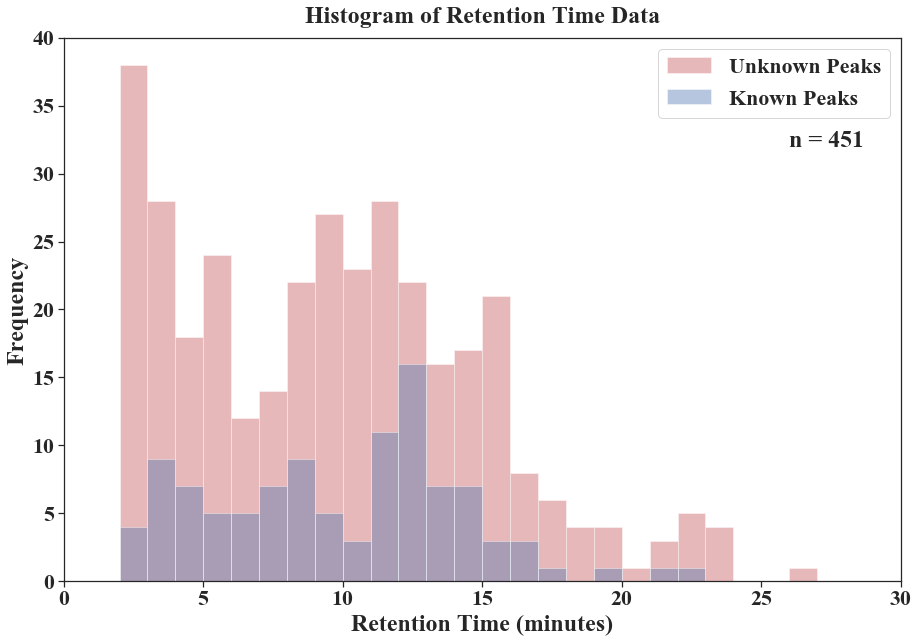

In [10]:
fig, ax = plt.subplots(figsize=(15, 10))

ax = sns.distplot(rt_unknown_data['RT (min)'], kde=False, bins=range(30), color='r')
ax = sns.distplot(labels_df, kde=False, bins=range(25))

ax.set_xlim(0, 30)
ax.set_xticks(range(0, 35, 5))

ax.set_ylim(0, 40)
ax.set_yticks(range(0, 45, 5))

ax.legend(['Unknown Peaks', 'Known Peaks'])

ax.set_xlabel('Retention Time (minutes)')
ax.set_ylabel('Frequency')

ax.text(x=26, y=32, s='n = {}'.format(len(rt_csv_data)))

ax.set_title('Histogram of Retention Time Data', pad=15)

plt.show()

fig.savefig(fig_filepath + 'rt_data_hist')

## Inspect Calculated Features

In [11]:
# Mordred leaves error messages in cells in df where value could not be calculated
# Replace all cells with error messages (strings) with np.nan using pd.to_numeric
features_df = features_df.apply(pd.to_numeric, errors='coerce')

features_df.to_csv('processed_data.csv')

features_df.head()

ABC     ABCGG  nAcid  nBase   SpAbs_A   SpMax_A  \
propionic acid  3.047207  3.305183      1      0  5.226252  1.847759   
pyruvic acid    3.932653  4.244375      1      0  6.000000  2.000000   
lactate         3.932653  4.244375      1      0  6.000000  2.000000   
alanine         3.932653  4.244375      1      1  6.000000  2.000000   
malonic acid    4.680200  4.942478      2      0  6.828427  2.000000   

                SpDiam_A    SpAD_A  SpMAD_A   LogEE_A  ...     SRW10  \
propionic acid  3.695518  5.226252  1.04525  2.408576  ...  6.834109   
pyruvic acid    4.000000  6.000000  1.00000  2.610845  ...  7.626083   
lactate         4.000000  6.000000  1.00000  2.610845  ...  7.626083   
alanine         4.000000  6.000000  1.00000  2.610845  ...  7.626083   
malonic acid    4.000000  6.828427  0.97549  2.765108  ...  7.655864   

                   TSRW10          MW       AMW  WPath  WPol  Zagreb1  \
propionic acid  27.254130   74.036779  6.730616     18     2     16.0   
pyruvic acid    30.698690   88.016044  8.801604     29     4     22.0   
lactate         30.698690   89.024418  8.093129     29     4     22.0   
alanine         30.698690   89.047678  6.849821     29     4     22.0   
malonic acid    32.211905  104.010959  9.455542     48     4     26.0   

                Zagreb2  mZagreb1  mZagreb2  
propionic acid     14.0  3.361111  1.333333  
pyruvic acid       21.0  4.222222  1.444444  
lactate            21.0  4.222222  1.444444  
alanine            21.0  4.222222  1.444444  
malonic acid       24.0  4.472222  1.666667  

[5 rows x 1826 columns]

In [12]:
features_df.describe()

ABC       ABCGG       nAcid       nBase     SpAbs_A     SpMax_A  \
count  105.000000  105.000000  105.000000  105.000000  105.000000  105.000000   
mean    10.737139    9.949713    1.533333    0.790476   16.880555    2.244995   
std      7.308685    5.466253    0.981234    1.071441   11.210324    0.172596   
min      3.047207    3.305183    0.000000    0.000000    5.226252    1.847759   
25%      6.651690    6.726049    1.000000    0.000000   10.175084    2.116883   
50%      8.284683    8.139582    1.000000    0.000000   13.333870    2.210509   
75%     11.520558   11.231509    2.000000    1.000000   18.550411    2.388640   
max     42.135164   31.576535    4.000000    4.000000   66.233797    2.541388   

         SpDiam_A      SpAD_A     SpMAD_A     LogEE_A  ...       SRW10  \
count  105.000000  105.000000  105.000000  105.000000  ...  105.000000   
mean     4.449998   16.880555    1.138648    3.417967  ...    8.941756   
std      0.296363   11.210324    0.083165    0.506497  ...    0.875938   
min      3.695518    5.226252    0.923081    2.408576  ...    6.834109   
25%      4.233766   10.175084    1.080882    3.123214  ...    8.308692   
50%      4.409447   13.333870    1.134917    3.314228  ...    8.733755   
75%      4.685846   18.550411    1.193886    3.635498  ...    9.432123   
max      5.055096   66.233797    1.309836    4.907875  ...   11.076233   

           TSRW10          MW         AMW         WPath        WPol  \
count  105.000000  105.000000  105.000000    105.000000  105.000000   
mean    48.868821  217.914025    8.287377    807.114286   18.371429   
std     17.882059  141.280151    1.340890   2060.727389   16.731050   
min     27.254130   74.036779    5.379573     18.000000    2.000000   
25%     37.326413  136.038511    7.270184    105.000000    8.000000   
50%     41.105781  172.146330    8.314844    188.000000   12.000000   
75%     55.364239  228.147392    9.224949    453.000000   21.000000   
max    108.252169  785.157135   11.198825  13425.000000   95.000000   

          Zagreb1     Zagreb2    mZagreb1    mZagreb2  
count  105.000000  105.000000  105.000000  105.000000  
mean    69.085714   76.666667    6.990807    3.248280  
std     52.518150   64.030441    3.426096    1.795959  
min     16.000000   14.000000    2.833333    1.333333  
25%     38.000000   39.000000    4.972222    2.250000  
50%     50.000000   52.000000    5.923611    2.750000  
75%     76.000000   85.000000    7.666667    3.583333  
max    294.000000  353.000000   20.972222   11.083333  

[8 rows x 1824 columns]

In [13]:
nan_df = features_df.apply(np.isnan)

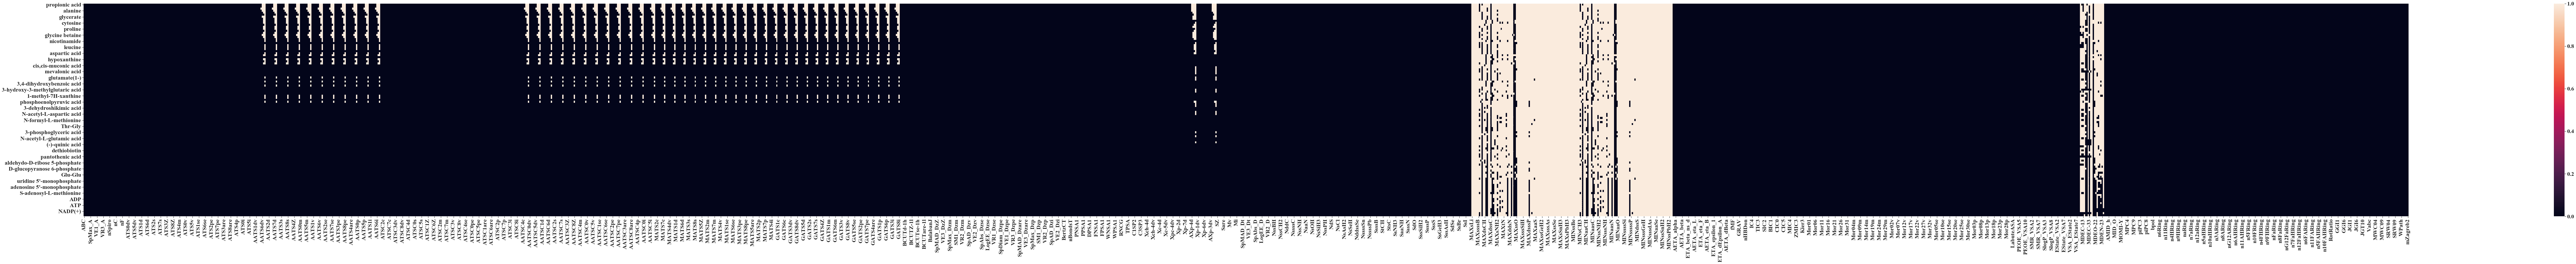

In [14]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(200, 15))

sns.heatmap(nan_df, ax=ax)

fig.savefig(fig_filepath + 'NaN_Feature_Heatmap')

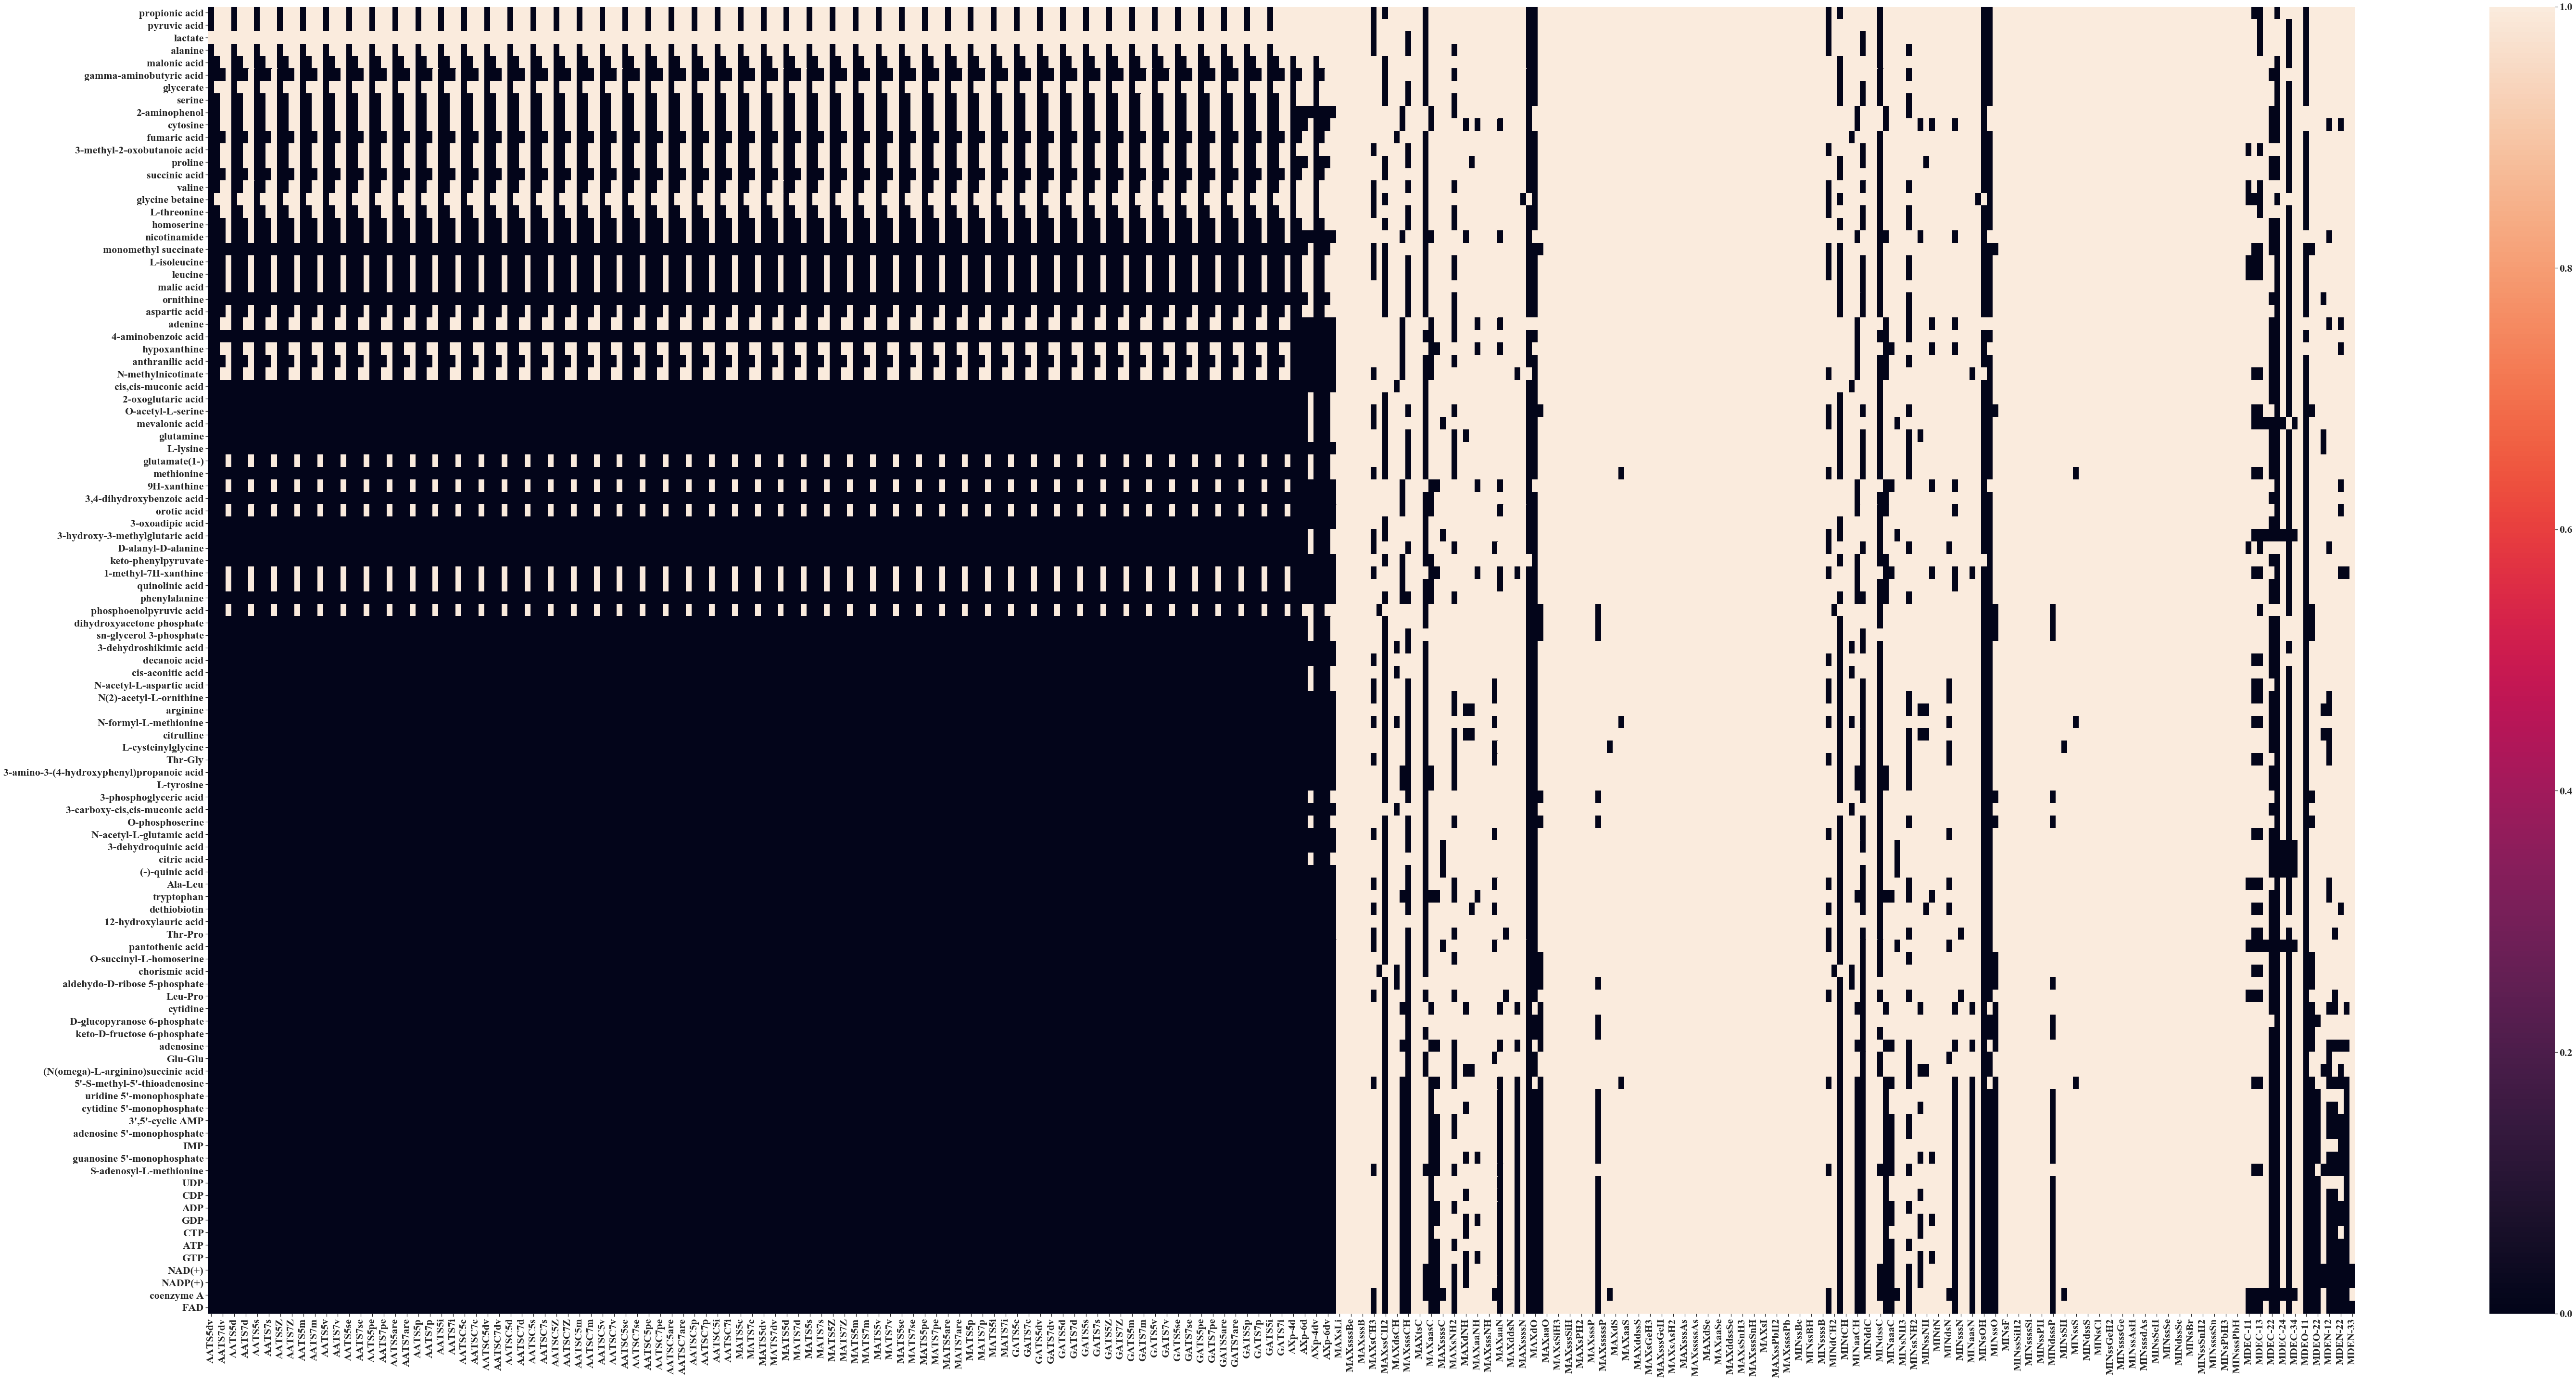

In [15]:
nan_cols = nan_df.columns[(nan_df > 0).any()]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(100, 50))

sns.heatmap(nan_df[nan_cols], ax=ax)

fig.savefig(fig_filepath + 'NaN_Only_Feature_Heatmap')

## Fill in Missing Data and Drop NaN Columns

* All np.nan values in **(X)ATS and AXp** descriptors are due to small molecule size as they describe paths of a given length through the molecule - replaced np.nan values with 0 since all non-NaN values are >= 0.

* All np.nan values in **(XX)SA(X)** descriptors are due to structures being in neutral form.

* **MAX and MIN** descriptors are np.nan due to nonpresence of a functional group or element (like Li or CH3) and describe electron configuration - dropped columns with all np.nan. For all others, replaced np.nan with 0.

* **MDE(X)** = Molecular Distance Edge between primary/secondary/tertiary atoms of element X in structure. Some molecules don't have two primary oxygens (MDEO-11) for example, resulting in np.nan. Replaced all np.nan with 0 since all non-NaN values are positive.


In [16]:
print('Number of columns before dropping NaN columns:', len(features_df.columns))
features_df = features_df.dropna(axis=1, how='all')
print('Number of columns after dropping NaN columns:', len(features_df.columns))

Number of columns before dropping NaN columns: 1826
Number of columns after dropping NaN columns: 1717


In [17]:
features_df = features_df.fillna(0)  # Replace all np.nan values with 0

In [18]:
new_nan_df = features_df.apply(np.isnan)
assert not new_nan_df.isnull().sum().any()  # Make sure we have no np.nan values in our dataframe

## Train RF Model with Default Params

In [19]:
regr = RandomForestRegressor(oob_score=True, random_state=0, criterion='mse')
regr.fit(features_df, rt_vals)

C:\Users\jonst\Anaconda3\envs\cbm\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\jonst\Anaconda3\envs\cbm\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=True, random_state=0, verbose=0, warm_start=False)

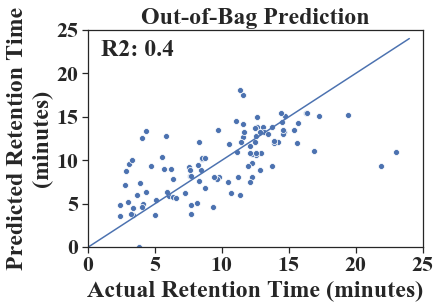

Mean Absolute Error (minutes): 2.53


In [20]:
ax = sns.scatterplot(rt_vals, regr.oob_prediction_)
ax.set_xlabel('Actual Retention Time (minutes)')
ax.set_ylabel('Predicted Retention Time\n(minutes)')
ax.set_title('Out-of-Bag Prediction')
ax.text(x=1, y=22, s='R2: {}'.format(round(regr.oob_score_, 2)))

ax.set_xlim(0, 25)
ax.set_xticks(range(0, 30, 5))

ax.set_ylim(0, 25)
ax.set_yticks(range(0, 30, 5))

sns.lineplot(range(25), range(25))

plt.show()

print('Mean Absolute Error (minutes):', round(mean_absolute_error(rt_vals, regr.oob_prediction_), 2))

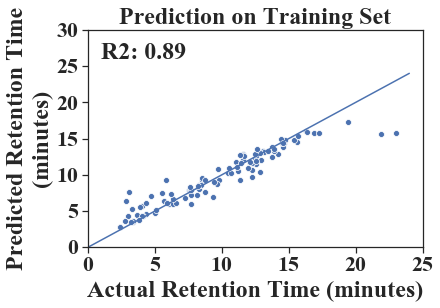

Mean Absolute Error (minutes): 0.92


In [21]:
ax = sns.scatterplot(rt_vals, regr.predict(features_df))
ax.set_xlabel('Actual Retention Time (minutes)')
ax.set_ylabel('Predicted Retention Time\n(minutes)')
ax.set_title('Prediction on Training Set')
ax.text(x=1, y=26, s='R2: {}'.format(round(r2_score(rt_vals, regr.predict(features_df)), 2)))

ax.set_xlim(0, 25)
ax.set_xticks(range(0, 30, 5))

ax.set_ylim(0, 30)
ax.set_yticks(range(0, 35, 5))

sns.lineplot(range(25), range(25))

plt.show()

print('Mean Absolute Error (minutes):', round(mean_absolute_error(rt_vals, regr.predict(features_df)), 2))

## Try varying number of trees

In [22]:
# n_estimators_list = []
# scores = []

tree_counts = [10, 30, 50, 75, 100, 150, 200, 250, 500, 1000]

# for random_state in range(1000):
#     for n_estimators in tree_counts:
#         regr = RandomForestRegressor(n_estimators=n_estimators, oob_score=True, random_state=random_state, criterion='mse',
#                                      warm_start=True)
#         regr.fit(features_df, rt_vals)
        
#         scores.append(regr.oob_score_)
#         n_estimators_list.append(n_estimators)
        
#         print(random_state, n_estimators, round(regr.oob_score_, 2))

In [23]:
# scores_dict = {}

# for i, tree_n in enumerate(tree_counts):
#     scores_for_tree_n = scores[slice(i, 10000, 10)]
#     scores_dict[tree_n] = scores_for_tree_n

In [24]:
# with open('scores_by_tree_count.pickle', 'wb') as infile:
#     pickle.dump(scores_dict, infile)

### We can also look at histograms considering only forests with specified number of trees

In [25]:
with open('scores_by_tree_count.pickle', 'rb') as infile:
    scores_dict = pickle.load(infile)
    scores = [score for tree_count in scores_dict for score in scores_dict[tree_count]]

In [26]:
best_param_i = np.argmax(scores)
best_random_state = int(best_param_i / 10)

print('Random State #' + str(best_random_state),
      'gave best Out-of-Bag score of', str(round(scores[best_param_i], 2)),
      'using {} trees.'.format(tree_counts[best_param_i % 10]))

Random State #293 gave best Out-of-Bag score of 0.66 using 50 trees.


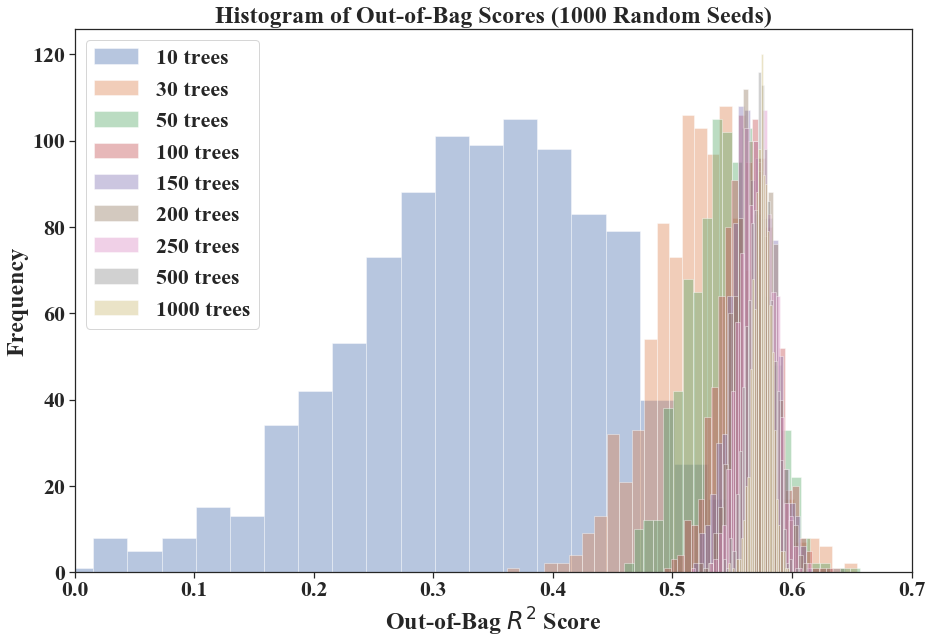

In [27]:
fig, ax = plt.subplots(figsize=(15, 10))

ax = sns.distplot(scores_dict[10], kde=False)
ax = sns.distplot(scores_dict[30], kde=False)
ax = sns.distplot(scores_dict[50], kde=False)
ax = sns.distplot(scores_dict[100], kde=False)
ax = sns.distplot(scores_dict[150], kde=False)
ax = sns.distplot(scores_dict[200], kde=False)
ax = sns.distplot(scores_dict[250], kde=False)
ax = sns.distplot(scores_dict[500], kde=False)
ax = sns.distplot(scores_dict[1000], kde=False)

ax.set_xlim(0, 0.7)

ax.set_xlabel('Out-of-Bag $R^2$ Score')
ax.set_ylabel('Frequency')

ax.legend(['10 trees', '30 trees', '50 trees', '100 trees', '150 trees', '200 trees', '250 trees', '500 trees',
           '1000 trees'])

ax.set_title('Histogram of Out-of-Bag Scores (1000 Random Seeds)')

plt.show()

fig.savefig(fig_filepath + 'varying_num_trees_hist')

Out-of-Bag score converges around 0.55 - 0.6 as we go up to 1,000 trees.

## Look at Important Features
### First, try drop column strategy

In [28]:
# random_states = []
# feature_names = []
# feature_indices = []
# old_oob_scores = []
# new_oob_scores = []

# for random_state in range(75):
#     regr = RandomForestRegressor(n_estimators=100, oob_score=True, random_state=random_state, criterion='mse')
#     regr.fit(features_df, rt_vals)
#     old_oob_score = regr.oob_score_
    
#     print('Random State', random_state)
    
#     for i, feature_to_drop in enumerate(features_df.columns):
#         new_features_df = features_df.drop(feature_to_drop, axis=1)

#         regr.fit(new_features_df, rt_vals)

#         random_states.append(random_state)
#         feature_names.append(feature_to_drop)
#         feature_indices.append(i)
#         old_oob_scores.append(old_oob_score)
#         new_oob_scores.append(regr.oob_score_)

In [29]:
feature_imp_df = pd.read_csv('Dropped_Feature_Stats.csv')

# feature_imp_df = pd.DataFrame()
# feature_imp_df['Random State'] = random_states
# feature_imp_df['Feature Dropped'] = feature_names
# feature_imp_df['Feature Index'] = feature_indices
# feature_imp_df['Out-of-Bag Score (Original)'] = old_oob_scores
# feature_imp_df['Out-of-Bag Score (Dropped Feature)'] = new_oob_scores
# feature_imp_df['Change in Out-of-Bag Score'] = \
#     feature_imp_df['Out-of-Bag Score (Original)'] - feature_imp_df['Out-of-Bag Score (Dropped Feature)']

feature_imp_df.head()

Unnamed: 0  Random State Feature Dropped  Feature Index  \
0           0             0             ABC              0   
1           1             0           ABCGG              1   
2           2             0           nAcid              2   
3           3             0           nBase              3   
4           4             0         SpAbs_A              4   

   Out-of-Bag Score (Original)  Out-of-Bag Score (Dropped Feature)  \
0                     0.463297                            0.508940   
1                     0.463297                            0.496685   
2                     0.463297                            0.453317   
3                     0.463297                            0.523141   
4                     0.463297                            0.491166   

   Change in Out-of-Bag Score  
0                    0.045643  
1                    0.033388  
2                   -0.009980  
3                    0.059844  
4                    0.027869

In [30]:
#feature_imp_df.to_csv('Dropped_Feature_Stats.csv')

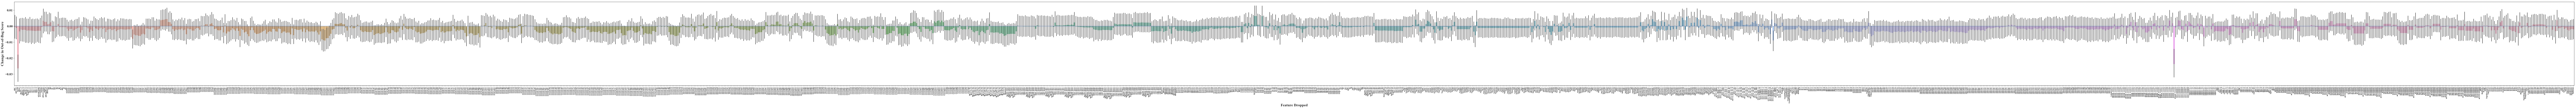

In [31]:
fig, ax = plt.subplots(figsize=(300, 10))

ax = sns.barplot(x='Feature Dropped', y='Change in Out-of-Bag Score', data=feature_imp_df)

ax.set_xticklabels(feature_imp_df['Feature Dropped'].unique(), rotation=90, fontsize=12)

ax.axhline(0)

fig.savefig(fig_filepath + 'drop_column_feature_importances')

In [32]:
keep_features_df = feature_imp_df.groupby('Feature Dropped').mean()
len(keep_features_df)

1718

In [33]:
keep_features_df.head()

Unnamed: 0  Random State  Feature Index  \
Feature Dropped                                            
AATS0Z                63727            37            161   
AATS0are              63772            37            206   
AATS0d                63709            37            143   
AATS0dv               63700            37            134   
AATS0i                63790            37            224   

                 Out-of-Bag Score (Original)  \
Feature Dropped                                
AATS0Z                              0.505032   
AATS0are                            0.505032   
AATS0d                              0.505032   
AATS0dv                             0.505032   
AATS0i                              0.505032   

                 Out-of-Bag Score (Dropped Feature)  \
Feature Dropped                                       
AATS0Z                                     0.500912   
AATS0are                                   0.496795   
AATS0d                                     0.501686   
AATS0dv                                    0.503234   
AATS0i                                     0.504998   

                 Change in Out-of-Bag Score  
Feature Dropped                              
AATS0Z                            -0.004120  
AATS0are                          -0.008237  
AATS0d                            -0.003346  
AATS0dv                           -0.001798  
AATS0i                            -0.000034

In [34]:
threshold = keep_features_df.at['Random', 'Change in Out-of-Bag Score']

kept_features = list(keep_features_df.index[keep_features_df['Change in Out-of-Bag Score'] < threshold])
#kept_features.remove('Random')

len(kept_features)

685

In [35]:
kept_features_df = features_df.drop(kept_features, axis=1)

In [36]:
regr = RandomForestRegressor(n_estimators=1000, oob_score=True, random_state=0, criterion='mse', max_features='sqrt')
regr.fit(kept_features_df, rt_vals)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=None,
           oob_score=True, random_state=0, verbose=0, warm_start=False)

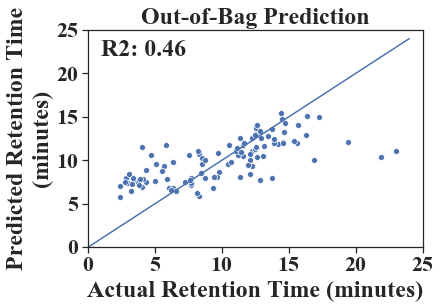

Mean Absolute Error (minutes): 2.4


In [37]:
ax = sns.scatterplot(rt_vals, regr.oob_prediction_)
ax.set_xlabel('Actual Retention Time (minutes)')
ax.set_ylabel('Predicted Retention Time\n(minutes)')
ax.set_title('Out-of-Bag Prediction')
ax.text(x=1, y=22, s='R2: {}'.format(round(regr.oob_score_, 2)))

ax.set_xlim(0, 25)
ax.set_xticks(range(0, 30, 5))

ax.set_ylim(0, 25)
ax.set_yticks(range(0, 30, 5))

sns.lineplot(range(25), range(25))

plt.show()

print('Mean Absolute Error (minutes):', round(mean_absolute_error(rt_vals, regr.oob_prediction_), 2))

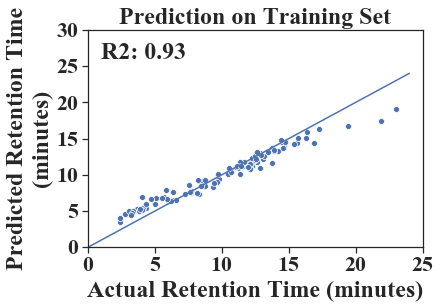

Mean Absolute Error (minutes): 0.88


In [38]:
ax = sns.scatterplot(rt_vals, regr.predict(kept_features_df))
ax.set_xlabel('Actual Retention Time (minutes)')
ax.set_ylabel('Predicted Retention Time\n(minutes)')
ax.set_title('Prediction on Training Set')
ax.text(x=1, y=26, s='R2: {}'.format(round(r2_score(rt_vals, regr.predict(kept_features_df)), 2)))

ax.set_xlim(0, 25)
ax.set_xticks(range(0, 30, 5))

ax.set_ylim(0, 30)
ax.set_yticks(range(0, 35, 5))

sns.lineplot(range(25), range(25))

plt.show()

print('Mean Absolute Error (minutes):', round(mean_absolute_error(rt_vals, regr.predict(kept_features_df)), 2))

We get some, but very little, improvement overall. Let's try the quicker SelectFromModel feature selection technique.

### Try sklearn default Feature Selection Strategy

In [39]:
# scores = []
# random_states = []
# max_features_list = []

# for random_state in range(20000):
    
#     if not random_state % 100:
#         print(random_state)
        
#     for max_features in list(range(2, 10)) + [10, 15, 20, 50, 100]:
#         regr = RandomForestRegressor(n_estimators=100, oob_score=True, random_state=random_state, criterion='mse',
#                                      max_features='sqrt')
#         regr.fit(features_df, rt_vals)
#         model = SelectFromModel(regr, max_features=max_features, prefit=True)
#         X_new = model.transform(features_df)
#         regr.fit(X_new, rt_vals)
#         X_new.shape

#         scores.append(regr.oob_score_)
#         random_states.append(random_state)
#         max_features_list.append(max_features)

In [40]:
# score_df = pd.DataFrame()

# score_df['Score'] = scores
# score_df['Random State'] = random_states
# score_df['Number of Features'] = max_features_list

In [41]:
# score_df.to_csv('feature_selection_scores.csv')
score_df = pd.read_csv('feature_selection_scores.csv')

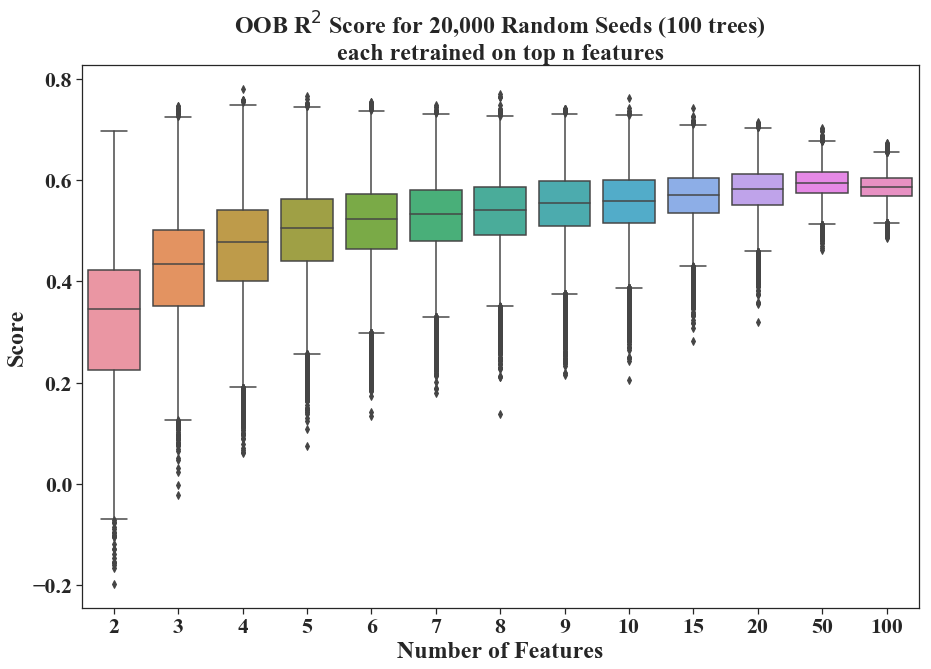

In [42]:
fig, ax = plt.subplots(figsize=(15, 10))

ax = sns.boxplot(x='Number of Features', y='Score', data=score_df)

ax.set_title('OOB R$^2$ Score for 20,000 Random Seeds (100 trees)\neach retrained on top n features')

plt.show()

fig.savefig(fig_filepath + 'sklearn_top_n_features_oob_scores')

In [43]:
high_score_ind = np.argmax(score_df['Score'])
score_df.iloc[high_score_ind, :]

C:\Users\jonst\Anaconda3\envs\cbm\lib\site-packages\numpy\core\fromnumeric.py:56: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return getattr(obj, method)(*args, **kwds)


Unnamed: 0            13678.000000
Score                     0.779387
Random State           1052.000000
Number of Features        4.000000
Name: 13678, dtype: float64

In [44]:
regr = RandomForestRegressor(n_estimators=100, oob_score=True, random_state=1052, criterion='mse',
                             max_features='sqrt')
regr.fit(features_df, rt_vals)
model = SelectFromModel(regr, max_features=4, prefit=True)
X_new = model.transform(features_df)
regr.fit(X_new, rt_vals)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=True, random_state=1052, verbose=0, warm_start=False)

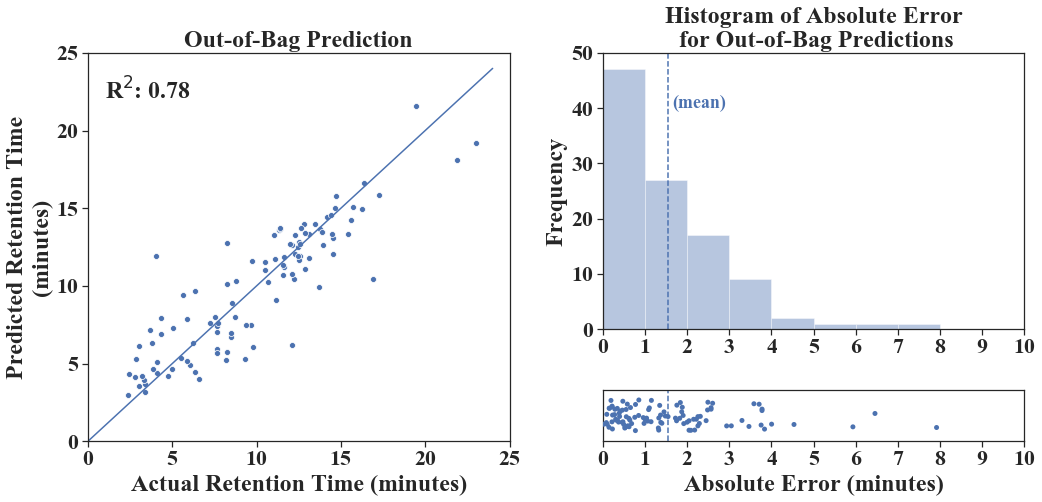

In [46]:
plt.subplots(figsize=(15, 7.5))

ax1 = plt.subplot2grid((4, 8), (0, 0), rowspan=4, colspan=4)
ax2 = plt.subplot2grid((4, 8), (0, 4), rowspan=3, colspan=4)
ax3 = plt.subplot2grid((4, 8), (3, 4), rowspan=1, colspan=4)

sns.scatterplot(rt_vals, regr.oob_prediction_, ax=ax1)
ax1.set_xlabel('Actual Retention Time (minutes)')
ax1.set_ylabel('Predicted Retention Time\n(minutes)')
ax1.set_title('Out-of-Bag Prediction')
ax1.text(x=1, y=22, s='R$^2$: {}'.format(round(regr.oob_score_, 2)))

ax1.set_xlim(0, 25)
ax1.set_xticks(range(0, 30, 5))

ax1.set_ylim(0, 25)
ax1.set_yticks(range(0, 30, 5))

sns.lineplot(range(25), range(25), ax=ax1)

residuals = abs(rt_vals - regr.oob_prediction_)

sns.distplot(residuals, kde=False, bins=range(10), ax=ax2)
sns.stripplot(residuals, jitter=.3, ax=ax3)

mae = mean_absolute_error(rt_vals, regr.oob_prediction_)
ax2.axvline(mae, ls='--')

mae = round(mean_absolute_error(rt_vals, regr.oob_prediction_), 2)
ax2.text(mae + 0.1, 40, '(mean)', color='b', fontsize=18)

ax2.set_ylim(0, 50)
ax2.set_ylabel('Frequency')
ax2.set_xlim(0, 10)
ax2.set_xticks(range(11))

ax2.set_title('Histogram of Absolute Error\n for Out-of-Bag Predictions')

ax3.axvline(mae, ls='--')

ax3.set_xlabel('Absolute Error (minutes)')
ax3.set_xticks(range(11))
ax3.set_xlim(0, 10)
ax3.set_yticks([])

plt.tight_layout()
plt.show()

## Investigate Top 4 Features

In [47]:
regr.fit(features_df, rt_vals)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=True, random_state=1052, verbose=0, warm_start=False)

In [48]:
top_i = sorted(range(len(regr.feature_importances_)), key=lambda i: regr.feature_importances_[i])[-4:][::-1]

In [49]:
print(top_i)
top_features = [features_df.columns[i] for i in top_i]
top_features_scores = [regr.feature_importances_[i] for i in top_i]
print(top_features)

[2, 1180, 952, 1469]
['nAcid', 'ETA_dEpsilon_D', 'NsNH2', 'MDEO-11']


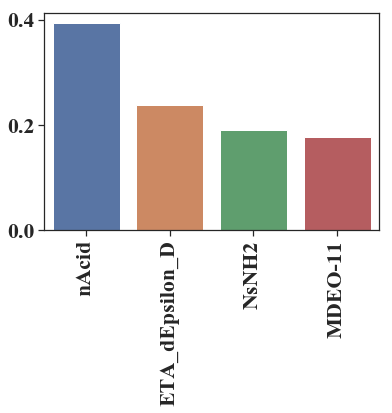

In [50]:
ax = sns.barplot(x=top_features, y=top_features_scores / sum(top_features_scores))  # (renormalize scores)
ax.set_xticklabels(top_features, rotation=90)

plt.show()

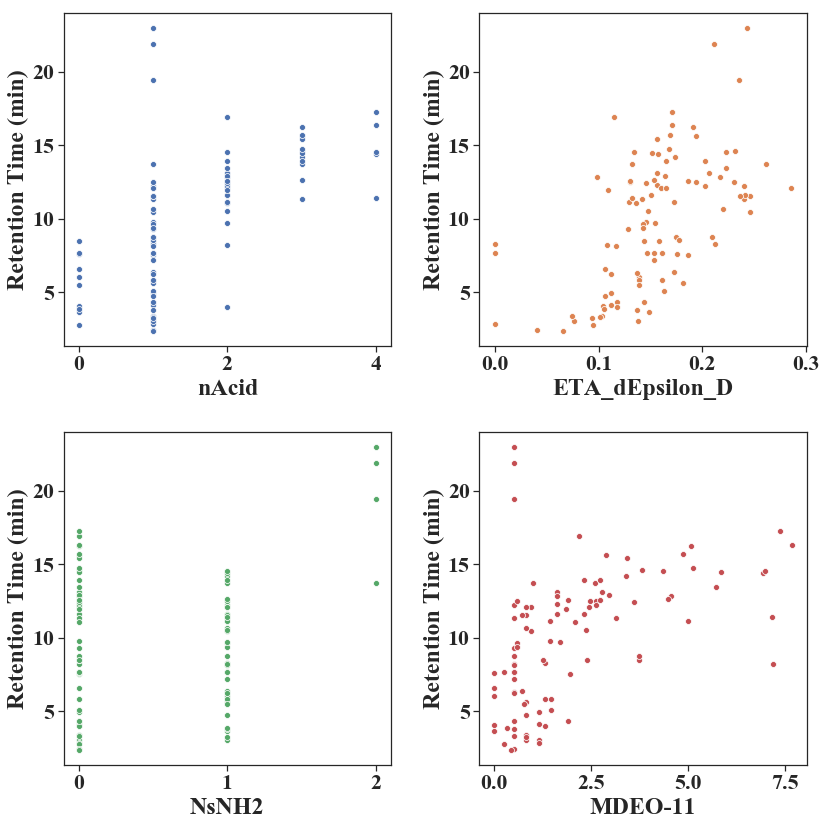

In [54]:
fig, axmatrix = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))

from sklearn.linear_model import LinearRegression

for j, (i, feature_name) in enumerate(zip(top_i, top_features)):
    row = int(j / 2)
    col = int(j % 2)
    ax = axmatrix[row, col]
    
    feature_vals = features_df.iloc[:, i]
    
#     lin_regr = LinearRegression()
#     lin_regr.fit(np.array(feature_vals).reshape(-1, 1), rt_vals.reshape(-1, 1))
    
#     r2 = r2_score(rt_vals.reshape(-1, 1), lin_regr.predict(np.array(feature_vals).reshape(-1, 1)))
    
#     ax.text(min(feature_vals), 20, 'R$^2$: {}'.format(round(r2, 2)))
    sns.scatterplot(feature_vals, rt_vals, ax=ax, color=sns.color_palette()[j])
    
    ax.set_ylabel('Retention Time (min)')

plt.tight_layout()

fig.savefig(fig_filepath + 'top_4_feature_correlations')

### Top Four Features

1. nAcid - Acidic group count
  * **Number of acidic groups in molecule**<br><br>
2. ETA_dEpsilon_D - ETA delta epsilon descriptor" (type: D)
  * ETA = Extended Topochemical Atom
  * $\Delta \epsilon_D = \epsilon_2 - \epsilon_5$ where $\epsilon$ is a measure of electronegativity
     * $\epsilon_2$ is average electronegativity for all non-hydrogen atoms
     * $\epsilon_5$ is average electronegativty of all non-hydrogen atoms and hydrogens not bonded to carbon
  * **Primarily captures electronegative effects of N-H and O-H bonds in molecule**<br><br>
3. NsNH2 - Number of sNH2
  * **Number of NH$_2$ groups in molecule**<br><br>
4. MDEO-11 - Molecular Distance Edge between Primary O and Primary O
  * Geometric mean of all topological (along bonds) distances between any two primary oxygen atoms in a molecule
  * **Average distance between primary oxygen atoms in molecule**

### Example Feature with 0 Importance
nHRing = Number of hetero rings.

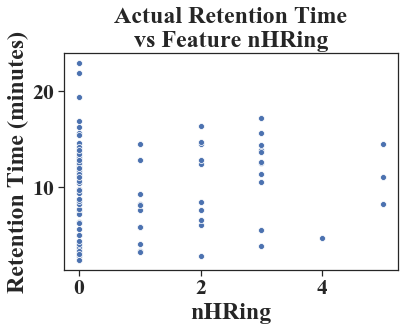

In [53]:
feature_name = 'nHRing'

ax = sns.scatterplot(features_df[feature_name], labels_df['Retention Time (minutes)'])

ax.set_title('Actual Retention Time\nvs Feature {}'.format(feature_name))

plt.show()

fig.savefig(fig_filepath + 'example_unimportant_feature')

### Look at LogP Value vs Retention Time
Since LogP is often used to predict retention time. However, it was not identified as a highly important feature here.

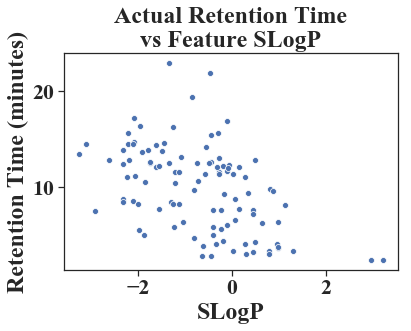

In [55]:
feature_name = 'SLogP'

ax = sns.scatterplot(features_df[feature_name], labels_df['Retention Time (minutes)'])

ax.set_title('Actual Retention Time\nvs Feature {}'.format(feature_name))

plt.show()

fig.savefig(fig_filepath + 'logp_correlation')

## Final Optimization of Random State with Top 4 Features
### Optimization of criterion parameter
MAE or MSE

In [58]:
# rs = []
# criteria = []
# scores = []

# for i in range(1000):
#     for criterion in ['mae', 'mse']:
#         regr = RandomForestRegressor(n_estimators=100, oob_score=True, random_state=i, criterion=criterion,
#                                      max_features='sqrt')
#         X = np.copy(X_new)

#         X_y = np.concatenate([X, rt_vals.reshape(-1, 1)], axis=1)
#         np.random.shuffle(X_y)
#         X = X_y[:, 0:4]
#         y = X_y[:, 4]

#         regr.fit(X, y)
        
#         scores.append(regr.oob_score_)
#         criteria.append(criterion)
#         rs.append(i)

In [63]:
# scores_df = pd.DataFrame()
# scores_df['Score'] = scores
# scores_df['Criteria'] = criteria
# scores_df['Random State'] = rs

# scores_df.to_csv('mae_vs_mse_scores.csv')
scores_df = pd.read_csv('mae_vs_mse_scores.csv')

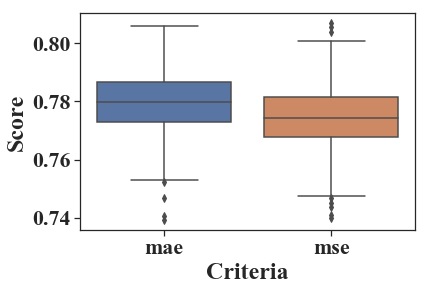

In [64]:
sns.boxplot(x='Criteria', y='Score', data=scores_df)

plt.savefig(fig_filepath + 'mae_vs_mse')

In [65]:
from scipy.stats import ttest_rel

In [73]:
mae_scores = scores_df.loc[scores_df.Criteria == 'mae']['Score']
mse_scores = scores_df.loc[scores_df.Criteria == 'mse']['Score']

pval = ttest_rel(mae_scores, mse_scores)[1]

print('p-value for paired t-test: {}'.format(pval))

p-value for paired t-test: 1.9705088345515626e-31


Will go with MAE over MSE for final model.

## Final Model

In [251]:
regr = RandomForestRegressor(n_estimators=1000, oob_score=True, random_state=1052, criterion='mae',
                             max_features='sqrt')
regr.fit(X_new, rt_vals)

RandomForestRegressor(bootstrap=True, criterion='mae', max_depth=None,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=None,
           oob_score=True, random_state=1052, verbose=0, warm_start=False)

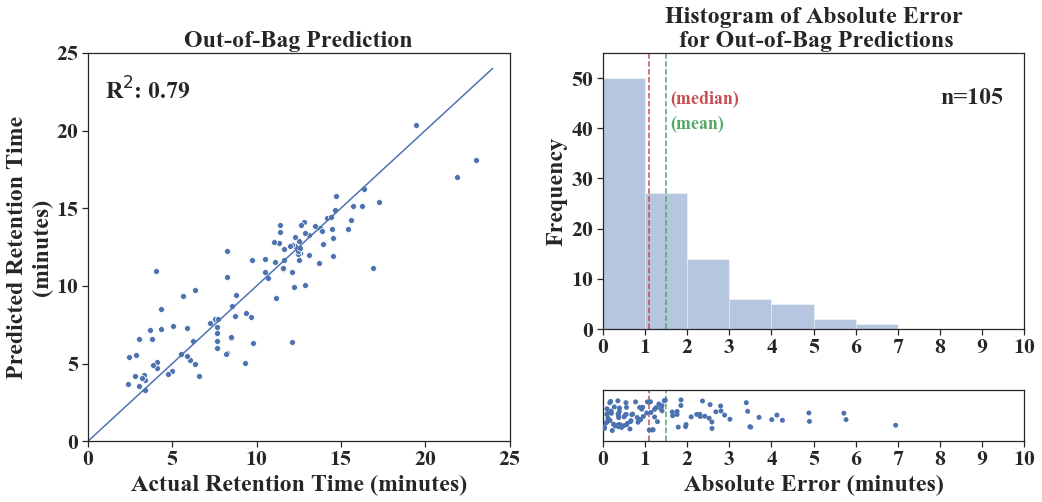

In [253]:
fig, ax = plt.subplots(figsize=(15, 7.5))

ax1 = plt.subplot2grid((4, 8), (0, 0), rowspan=4, colspan=4)
ax2 = plt.subplot2grid((4, 8), (0, 4), rowspan=3, colspan=4)
ax3 = plt.subplot2grid((4, 8), (3, 4), rowspan=1, colspan=4)

sns.scatterplot(rt_vals, regr.oob_prediction_, ax=ax1)
ax1.set_xlabel('Actual Retention Time (minutes)')
ax1.set_ylabel('Predicted Retention Time\n(minutes)')
ax1.set_title('Out-of-Bag Prediction')
ax1.text(x=1, y=22, s='R$^2$: {0:.2f}'.format(round(regr.oob_score_, 2)))

ax1.set_xlim(0, 25)
ax1.set_xticks(range(0, 30, 5))

ax1.set_ylim(0, 25)
ax1.set_yticks(range(0, 30, 5))

sns.lineplot(range(25), range(25), ax=ax1)

residuals = abs(rt_vals - regr.oob_prediction_)

sns.distplot(residuals, kde=False, bins=range(10), ax=ax2)
sns.stripplot(residuals, jitter=.3, ax=ax3)

mae = mean_absolute_error(rt_vals, regr.oob_prediction_)
median = np.median(abs(rt_vals - regr.oob_prediction_))

ax2.axvline(median, ls='--', color='r')
ax2.axvline(mae, ls='--', color='g')

ax2.text(mae + 0.1, 40, '(mean)', color='g', fontsize=18)

ax2.text(mae + 0.1, 45, '(median)', color='r', fontsize=18)

ax2.set_ylim(0, 55)
ax2.set_ylabel('Frequency')
ax2.set_xlim(0, 10)
ax2.set_xticks(range(11))

ax2.text(8, 45, 'n={}'.format(len(rt_vals)))

ax2.set_title('Histogram of Absolute Error\n for Out-of-Bag Predictions')

ax3.axvline(mae, ls='--', color='g')
ax3.axvline(median, ls='--', color='r')

ax3.set_xlabel('Absolute Error (minutes)')
ax3.set_xticks(range(11))
ax3.set_xlim(0, 10)
ax3.set_yticks([])

plt.tight_layout()
plt.show()

fig.savefig(fig_filepath + 'final_model_results')

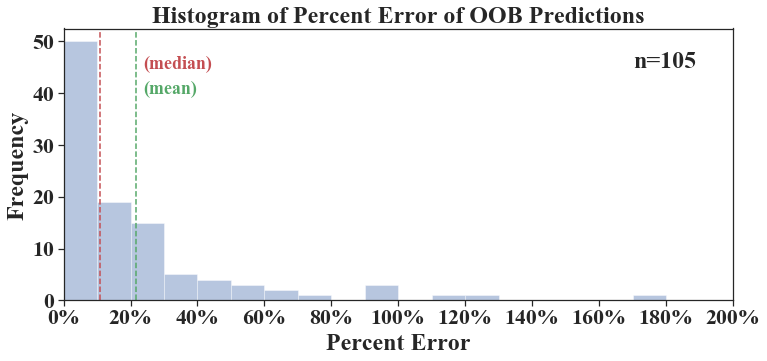

In [254]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 5))

pct_error = abs(rt_vals - regr.oob_prediction_) / rt_vals
sns.distplot(pct_error, kde=False, bins=np.arange(0, 2.2, 0.10))

ax.set_xlim(0, 2)
ax.set_xticks(np.arange(0, 2.2, 0.20))
ax.set_xticklabels([str(i) + '%' for i in range(0, 220, 20)])

ax.set_xlabel('Percent Error')
ax.set_ylabel('Frequency')
ax.set_title('Histogram of Percent Error of OOB Predictions')

ax.text(1.7, 45, 'n={}'.format(len(rt_vals)))

median = np.median(pct_error)
mean = np.mean(pct_error)

ax.axvline(mean, ls='--', color='g')
ax.axvline(median, ls='--', color='r')

ax.text(mean + 0.02, 40, '(mean)', color='g', fontsize=18)
ax.text(mean + 0.02, 45, '(median)', color='r', fontsize=18)

plt.show()

fig.savefig(fig_filepath + 'pct_error_final_model')

In [255]:
print('Metabolites with percent error greater than 50%:')
error_df[error_df['Percent Error'] > 50]

Metabolites with percent error greater than 50%:


Metabolite  Retention Time  Percent Error
0          propionic acid        4.330000      66.733735
8           2-aminophenol        3.698317      94.331212
28       anthranilic acid        3.783633      73.850293
30   cis,cis-muconic acid        4.034392     172.152506
32      O-acetyl-L-serine        6.360000      53.511221
43     D-alanyl-D-alanine        5.648350      65.611721
44    keto-phenylpyruvate        2.841383      94.355769
45   1-methyl-7H-xanthine        2.780000      50.579283
52          decanoic acid        2.419633     124.638921
70                Ala-Leu        3.054517     114.872243
73  12-hydroxylauric acid        2.367758      56.163882
75       pantothenic acid        4.359158      94.730069

### Results on Training Data

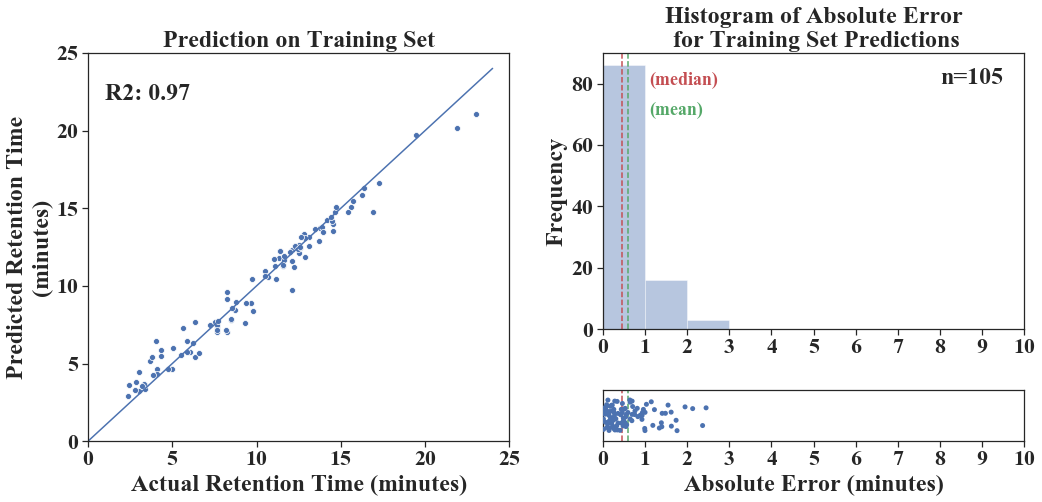

In [256]:
fig, ax = plt.subplots(figsize=(15, 7.5))

ax1 = plt.subplot2grid((4, 8), (0, 0), rowspan=4, colspan=4)
ax2 = plt.subplot2grid((4, 8), (0, 4), rowspan=3, colspan=4)
ax3 = plt.subplot2grid((4, 8), (3, 4), rowspan=1, colspan=4)

sns.scatterplot(rt_vals, regr.predict(X_new), ax=ax1)
ax1.set_xlabel('Actual Retention Time (minutes)')
ax1.set_ylabel('Predicted Retention Time\n(minutes)')
ax1.set_title('Prediction on Training Set')
ax1.text(x=1, y=22, s='R2: {}'.format(round(r2_score(rt_vals, regr.predict(X_new)), 2)))

ax1.set_xlim(0, 25)
ax1.set_xticks(range(0, 30, 5))

ax1.set_ylim(0, 25)
ax1.set_yticks(range(0, 30, 5))

sns.lineplot(range(25), range(25), ax=ax1)

residuals = abs(rt_vals - regr.predict(X_new))

sns.distplot(residuals, kde=False, bins=range(10), ax=ax2)
sns.stripplot(residuals, jitter=.3, ax=ax3)

mae = mean_absolute_error(rt_vals, regr.predict(X_new))
median = np.median(abs(rt_vals - regr.predict(X_new)))

ax2.axvline(median, ls='--', color='r')
ax2.axvline(mae, ls='--', color='g')

ax2.text(mae + 0.5, 70, '(mean)', color='g', fontsize=18)

ax2.text(mae + 0.5, 80, '(median)', color='r', fontsize=18)

ax2.set_ylim(0, 90)
ax2.set_ylabel('Frequency')
ax2.set_xlim(0, 10)
ax2.set_xticks(range(11))

ax2.text(8, 80, 'n={}'.format(len(rt_vals)))

ax2.set_title('Histogram of Absolute Error\n for Training Set Predictions')

ax3.axvline(mae, ls='--', color='g')
ax3.axvline(median, ls='--', color='r')

ax3.set_xlabel('Absolute Error (minutes)')
ax3.set_xticks(range(11))
ax3.set_xlim(0, 10)
ax3.set_yticks([])

plt.tight_layout()
plt.show()

fig.savefig(fig_filepath + 'final_model_results_training')

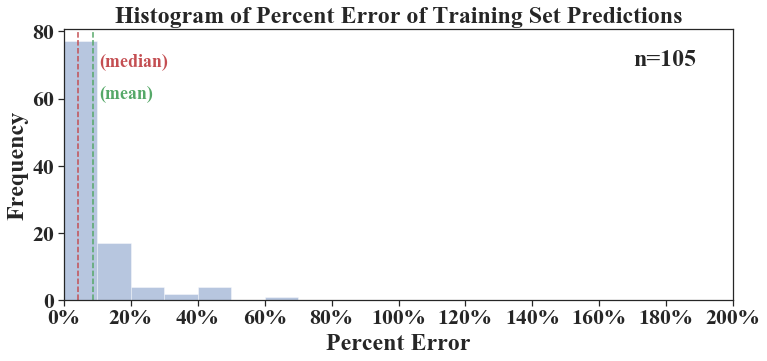

In [257]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 5))

pct_error = abs(rt_vals - regr.predict(X_new)) / rt_vals
sns.distplot(pct_error, kde=False, bins=np.arange(0, 2.2, 0.10))

ax.set_xlim(0, 2)
ax.set_xticks(np.arange(0, 2.2, 0.20))
ax.set_xticklabels([str(i) + '%' for i in range(0, 220, 20)])

ax.set_xlabel('Percent Error')
ax.set_ylabel('Frequency')
ax.set_title('Histogram of Percent Error of Training Set Predictions')

ax.text(1.7, 70, 'n={}'.format(len(rt_vals)))

median = np.median(pct_error)
mean = np.mean(pct_error)

ax.axvline(mean, ls='--', color='g')
ax.axvline(median, ls='--', color='r')

ax.text(mean + 0.02, 60, '(mean)', color='g', fontsize=18)
ax.text(mean + 0.02, 70, '(median)', color='r', fontsize=18)

plt.show()

fig.savefig(fig_filepath + 'pct_error_final_model_training')

## Retrain without changed data to see difference in accuracy

In [258]:
changed_i = [rt_known_data.index.get_loc(changed_data_chebis[i]) for i in range(len(changed_data_chebis))]
unchanged_i = [i for i in range(len(rt_vals)) if i not in changed_i]

In [259]:
rt_vals_unchanged = rt_vals[unchanged_i]
X_new_unchanged = X_new[unchanged_i]

In [260]:
regr.fit(X_new_unchanged, rt_vals_unchanged)

RandomForestRegressor(bootstrap=True, criterion='mae', max_depth=None,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=None,
           oob_score=True, random_state=1052, verbose=0, warm_start=False)

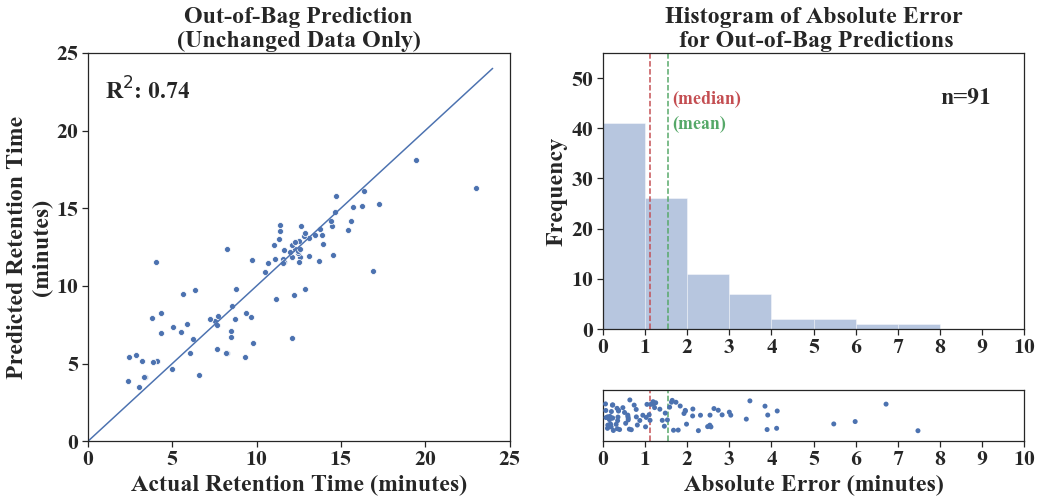

In [261]:
fig, ax = plt.subplots(figsize=(15, 7.5))

ax1 = plt.subplot2grid((4, 8), (0, 0), rowspan=4, colspan=4)
ax2 = plt.subplot2grid((4, 8), (0, 4), rowspan=3, colspan=4)
ax3 = plt.subplot2grid((4, 8), (3, 4), rowspan=1, colspan=4)

sns.scatterplot(rt_vals_unchanged, regr.oob_prediction_, ax=ax1)
ax1.set_xlabel('Actual Retention Time (minutes)')
ax1.set_ylabel('Predicted Retention Time\n(minutes)')
ax1.set_title('Out-of-Bag Prediction\n(Unchanged Data Only)')
ax1.text(x=1, y=22, s='R$^2$: {0:.2f}'.format(round(regr.oob_score_, 2)))

ax1.set_xlim(0, 25)
ax1.set_xticks(range(0, 30, 5))

ax1.set_ylim(0, 25)
ax1.set_yticks(range(0, 30, 5))

sns.lineplot(range(25), range(25), ax=ax1)

residuals = abs(rt_vals_unchanged - regr.oob_prediction_)

sns.distplot(residuals, kde=False, bins=range(10), ax=ax2)
sns.stripplot(residuals, jitter=.3, ax=ax3)

mae = round(mean_absolute_error(rt_vals_unchanged, regr.oob_prediction_), 2)
median = np.median(abs(rt_vals_unchanged - regr.oob_prediction_))

ax2.axvline(median, ls='--', color='r')
ax2.axvline(mae, ls='--', color='g')

ax2.text(mae + 0.1, 40, '(mean)', color='g', fontsize=18)

ax2.text(mae + 0.1, 45, '(median)', color='r', fontsize=18)

ax2.set_ylim(0, 55)
ax2.set_ylabel('Frequency')
ax2.set_xlim(0, 10)
ax2.set_xticks(range(11))

ax2.text(8, 45, 'n={}'.format(len(rt_vals_unchanged)))

ax2.set_title('Histogram of Absolute Error\n for Out-of-Bag Predictions')

ax3.axvline(mae, ls='--', color='g')
ax3.axvline(median, ls='--', color='r')

ax3.set_xlabel('Absolute Error (minutes)')
ax3.set_xticks(range(11))
ax3.set_xlim(0, 10)
ax3.set_yticks([])

plt.tight_layout()
plt.show()

fig.savefig(fig_filepath + 'final_model_results_unchanged_data_only')

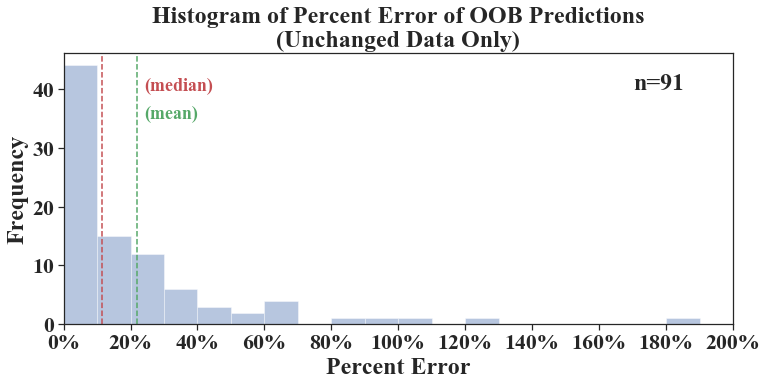

In [262]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 5))

pct_error = abs(rt_vals_unchanged - regr.oob_prediction_) / rt_vals_unchanged
sns.distplot(pct_error, kde=False, bins=np.arange(0, 2.2, 0.10))

ax.set_xlim(0, 2)
ax.set_xticks(np.arange(0, 2.2, 0.20))
ax.set_xticklabels([str(i) + '%' for i in range(0, 220, 20)])

ax.set_xlabel('Percent Error')
ax.set_ylabel('Frequency')
ax.set_title('Histogram of Percent Error of OOB Predictions\n(Unchanged Data Only)')

ax.text(1.7, 40, 'n={}'.format(len(rt_vals_unchanged)))

median = np.median(pct_error)
mean = np.mean(pct_error)

ax.axvline(mean, ls='--', color='g')
ax.axvline(median, ls='--', color='r')

ax.text(mean + 0.02, 35, '(mean)', color='g', fontsize=18)
ax.text(mean + 0.02, 40, '(median)', color='r', fontsize=18)

plt.show()

fig.savefig(fig_filepath + 'pct_error_final_model_training_unchanged_data_only')

## For Final Model, Plot OOB Score vs. Amount Data Used

In [281]:
regr = RandomForestRegressor(n_estimators=1000, oob_score=True, random_state=1052, criterion='mae',
                             max_features='sqrt')

num_runs_dict = {0.1: 100, 0.2: 50, 0.3: 20, 0.4: 20, 0.5: 10,
                 0.6: 10, 0.7: 10, 0.7: 10, 0.8: 10, 0.9: 10, 1.0: 1}

prop_data_col = []
run_num_col = []
score_col = []

for proportion_data in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:
    for run_i in range(num_runs_dict[proportion_data]):
        X = np.copy(X_new)

        X_y = np.concatenate([X, rt_vals.reshape(-1, 1)], axis=1)
        inds = list(range(len(X_y)))
        inds = np.random.choice(inds, size=int(proportion_data * len(X)), replace=False)
        X_y = X_y[inds]
        X = X_y[:, 0:3]
        y = X_y[:, 3]

        regr.fit(X, y)
        
        prop_data_col.append(proportion_data)
        run_num_col.append(run_i)
        score_col.append(regr.oob_score_)

In [282]:
data_score_df = pd.DataFrame()

data_score_df['Proportion Data Used'] = prop_data_col
data_score_df['Run Number'] = run_num_col
data_score_df['OOB Score'] = score_col

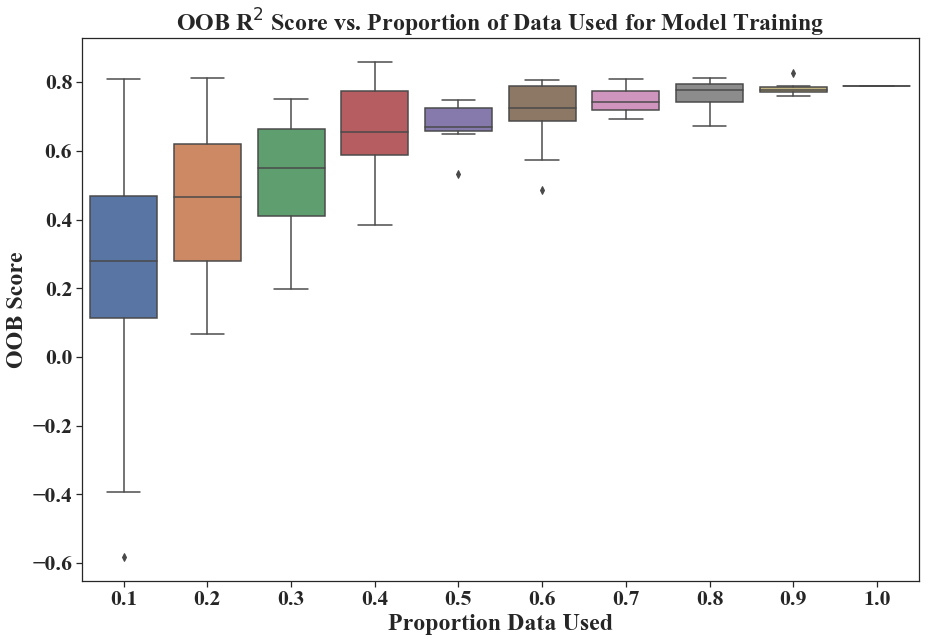

In [284]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 10))

sns.boxplot(x='Proportion Data Used', y='OOB Score', data=data_score_df, ax=ax)

ax.set_title('OOB R$^2$ Score vs. Proportion of Data Used for Model Training')

fig.savefig(fig_filepath + 'OOB_vs_proportion_data_used')

## Save Final Model

In [287]:
regr = RandomForestRegressor(n_estimators=1000, oob_score=True, random_state=1052, criterion='mae',
                             max_features='sqrt')

regr.fit(X_new, rt_vals)

regr.oob_score_

0.7873380927978291

In [288]:
import pickle

In [289]:
with open('final_RT_model.pickle', 'wb') as outfile:
    pickle.dump(regr, outfile)

In [291]:
pd.DataFrame(top_features).to_csv('final_features.csv')

['nAcid', 'ETA_dEpsilon_D', 'NsNH2', 'MDEO-11']


### Make sure we can open it

In [292]:
with open('final_RT_model.pickle', 'rb') as infile:
    regr = pickle.load(infile)

In [294]:
regr.oob_score_

0.7873380927978291

# Other Stuff (can ignore)
### Try SGDRegressor

In [141]:
from sklearn.linear_model import SGDRegressor

In [188]:
norm_features_df = StandardScaler().fit_transform(features_df)
norm_rt_vals = StandardScaler().fit_transform(rt_vals.reshape(-1,1))

C:\Users\jonst\Anaconda3\envs\cbm\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\jonst\Anaconda3\envs\cbm\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [244]:
regr = SGDRegressor(max_iter=1000000, tol=1e-3)
regr.fit(norm_features_df[:, top_i], norm_rt_vals)

C:\Users\jonst\Anaconda3\envs\cbm\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
       eta0=0.01, fit_intercept=True, l1_ratio=0.15,
       learning_rate='invscaling', loss='squared_loss', max_iter=1000000,
       n_iter=None, n_iter_no_change=5, penalty='l2', power_t=0.25,
       random_state=None, shuffle=True, tol=0.001, validation_fraction=0.1,
       verbose=0, warm_start=False)

In [250]:
r2_score(norm_rt_vals[:,0], regr.predict(norm_features_df[:, top_i]))

0.59417850190179

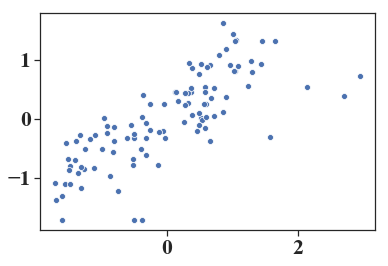

In [249]:
sns.scatterplot(norm_rt_vals[:,0], regr.predict(norm_features_df[:, top_i]))

### Original Feature Importances
### First, look at features > 0.1% importance
1. EState_VSA9 - EState VSA Descriptor 9 (4.69 <= x < 9.17)
  * Mordred Docs: "EState VSA Descriptor 9 (4.69 <= x < 9.17)"
  * E-State = [Electrotopological State](https://pubs.acs.org/doi/full/10.1021/ci990140w)
  * VSA = Van der Walls Surface Area
  * Calculates VSA contributed only from atoms with E-State between 4.69 and 9.17 (highly electronegative)
  * **Primarily captures amount of electronegative surface area.**

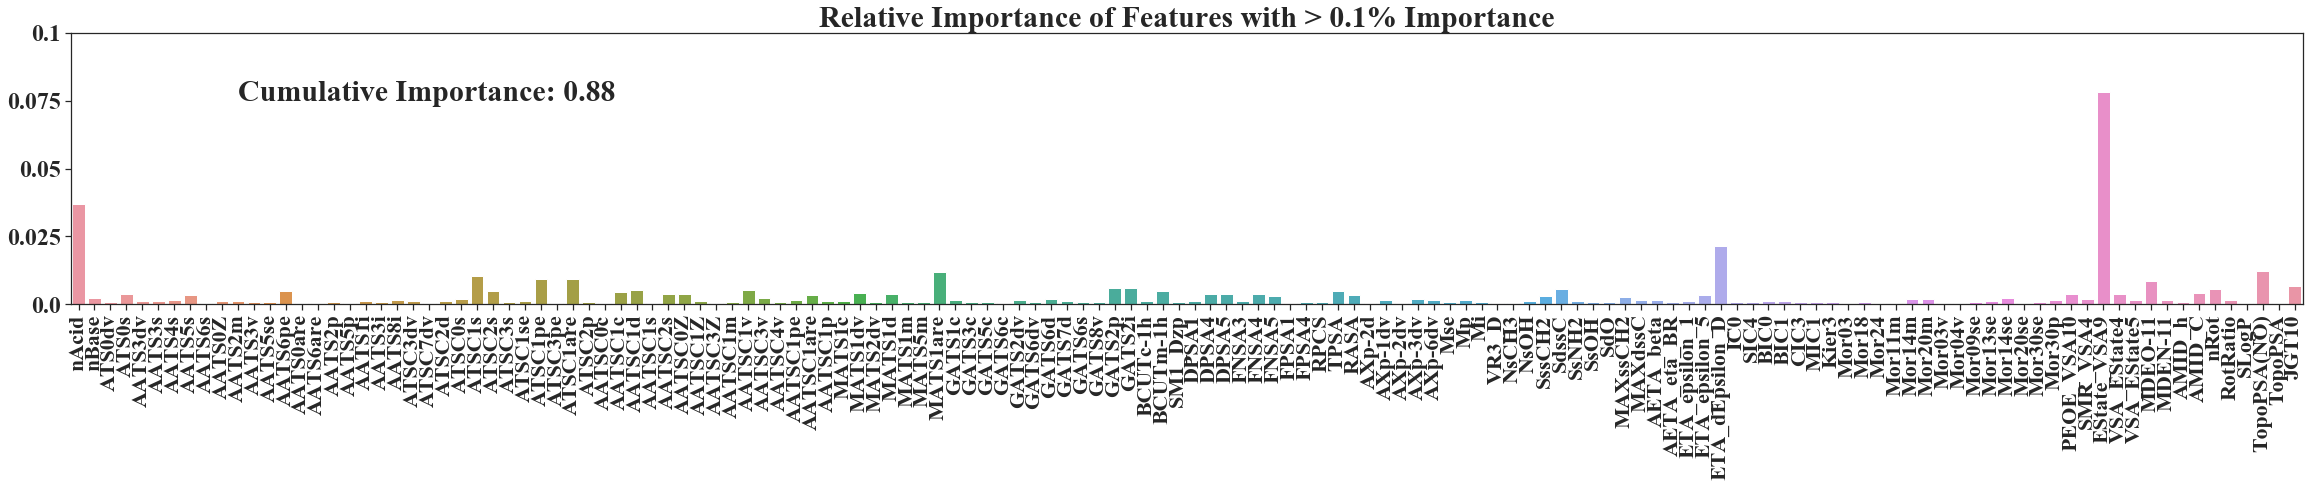

In [1443]:
fig, ax = plt.subplots(figsize=(40, 5))

sns.barplot(x=important_features, y=feature_importances, ax=ax)
ax.set_xticklabels(important_features, rotation=90)

ax.set_yticklabels([round(i, 3) for i in np.arange(0, 0.225, 0.025)], fontsize=24)
ax.set_ylim(0, .2)

ax.text(10, 0.15, 'Cumulative Importance: {}'.format(round(cum_imp, 2)), fontsize=30)

ax.set_title('Relative Importance of Features with > 0.1% Importance', fontsize=30)

plt.show()

### Look at features > 1% importance

In [1444]:
cutoff = 0.01

important_features = features_df.columns[regr.feature_importances_ > cutoff]
feature_importances = regr.feature_importances_[regr.feature_importances_ > cutoff]
cum_imp = sum(feature_importances)

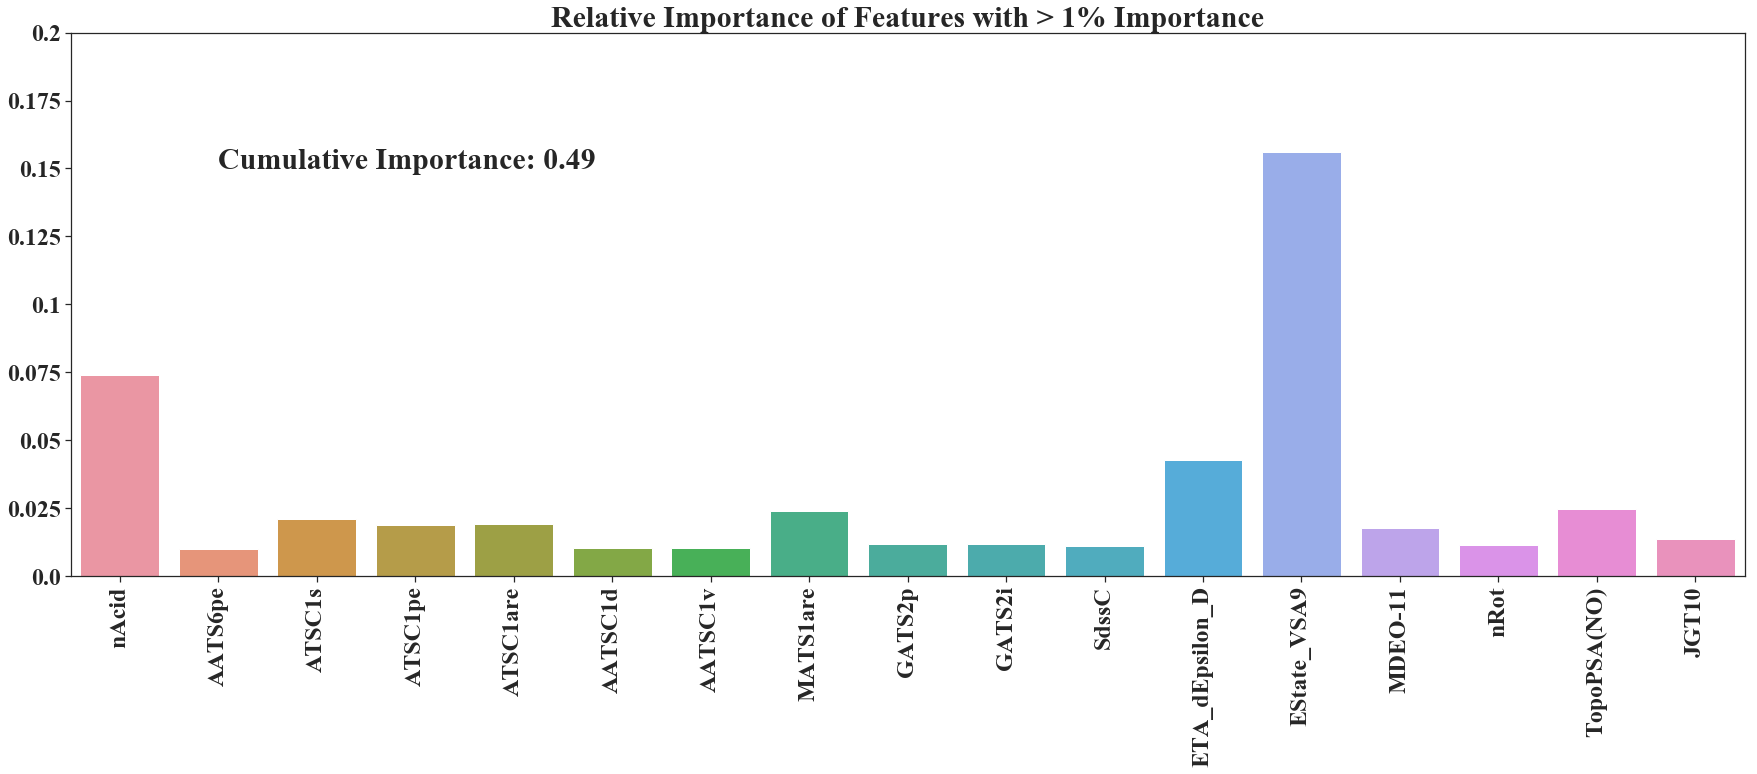

In [1445]:
fig, ax = plt.subplots(figsize=(30, 10))

sns.barplot(x=important_features, y=feature_importances, ax=ax)
ax.set_xticklabels(important_features, rotation=90, fontsize=24)

ax.set_yticklabels([round(i, 3) for i in np.arange(0, 0.225, 0.025)], fontsize=24)
ax.set_ylim(0, .2)

ax.text(1, 0.15, 'Cumulative Importance: {}'.format(round(cum_imp, 2)), fontsize=30)

ax.set_title('Relative Importance of Features with > 1% Importance', fontsize=30)

plt.show()

### Play with other parameters to see if we get further improvement
Such as max_features, max_depth, max_leaf_nodes, min_impurity_decrease, etc.

In [873]:
n_features = features_df.shape[1]
space  = [Integer(55, 56, name='n_estimators'),
          Integer(1, 1000, name='max_depth'),
          Real(0.00001, 0.1, "log-uniform", name='min_impurity_decrease'),
          Integer(1, n_features, name='max_features'),
          Integer(2, 10, name='min_samples_split'),
          Integer(1, 5, name='min_samples_leaf')]

In [868]:
@use_named_args(space)
def objective(**params):
    regr.set_params(**params)
    
    regr.fit(features_df, np.ravel(labels_df))

    return -regr.oob_score_

In [869]:
res_gp = gp_minimize(objective, space, n_calls=100, random_state=932, verbose=False)

print("Best score=%.4f" % -res_gp.fun)
print("""Best parameters:
     - n_estimators=%d
     - max_depth=%d
     - min_impurity_decrease=%d
     - max_features=%d
     - min_samples_split=%d
     - min_samples_leaf=%d"""
     % (res_gp.x[0], res_gp.x[1], res_gp.x[2], res_gp.x[3], res_gp.x[4], res_gp.x[5]))

C:\Users\jonst\Anaconda3\envs\cbm\lib\site-packages\skopt\optimizer\optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\jonst\Anaconda3\envs\cbm\lib\site-packages\skopt\optimizer\optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\jonst\Anaconda3\envs\cbm\lib\site-packages\skopt\optimizer\optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\jonst\Anaconda3\envs\cbm\lib\site-packages\skopt\optimizer\optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Best score=0.6670
Best parameters:
     - n_estimators=55
     - max_depth=519
     - min_impurity_decrease=0
     - max_features=1504
     - min_samples_split=2
     - min_samples_leaf=1


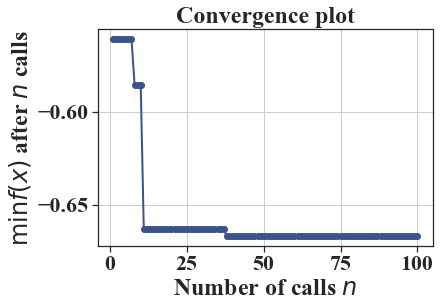

In [870]:
plot_convergence(res_gp)

Looks like default parameters are best (other than n_estimators).

### Try PCA on Features
See if PCA helps improve OOB score

In [398]:
regr = RandomForestRegressor(n_estimators=100, oob_score=True, random_state=2, criterion='mse')

In [399]:
norm_features_df = StandardScaler().fit_transform(features_df)

C:\Users\jonst\Anaconda3\envs\cbm\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\jonst\Anaconda3\envs\cbm\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


18 principal components explain 90% of total variance.


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=True, random_state=2, verbose=0, warm_start=False)

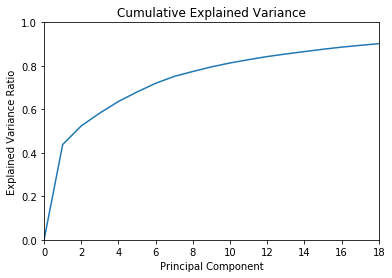

In [400]:
pca = PCA(0.9)

principal_components = pca.fit_transform(norm_features_df)

n_components = pca.n_components_
print(n_components, 'principal components explain 90% of total variance.')

pc_df = pd.DataFrame(data=principal_components, columns=['PC{}'.format(i) for i in range(1,n_components + 1)])

cum_ex_var = [0]

for i in range(1, n_components + 1):
    cum_ex_var.append(sum(pca.explained_variance_ratio_[:i]))

ax = sns.lineplot(range(0, n_components + 1), cum_ex_var)
ax.set_ylim(0, 1)
ax.set_xlim(0, n_components)
ax.set_xlabel('Principal Component')
ax.set_ylabel('Explained Variance Ratio')
ax.set_title('Cumulative Explained Variance')

regr.fit(pc_df, rt_vals)

R2: 0.3207573481284052


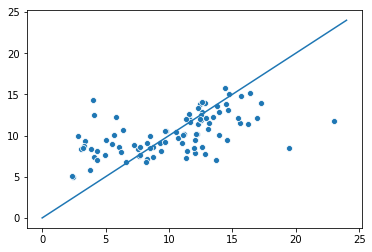

In [401]:
sns.scatterplot(rt_vals, regr.oob_prediction_)
sns.lineplot(range(25), range(25))
print('R2:', regr.oob_score_)

### Try Gradient Boosting

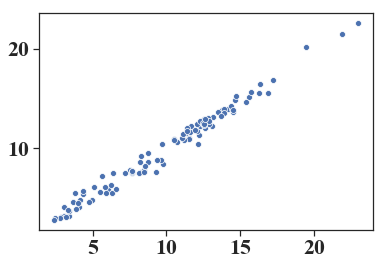

In [298]:
regr = GradientBoostingRegressor()
regr.fit(X_new, rt_vals)
sns.scatterplot(np.ravel(rt_vals), regr.predict(X_new))

In [299]:
regr.feature_importances_

array([0.32851482, 0.23146014, 0.32088221, 0.11914284])

In [310]:
from sklearn.model_selection import KFold

In [395]:
mean_scores = []
mean_maes = []

X = np.array(features_df)

for i in range(100):
    kf = KFold(n_splits=10, shuffle=True)
    kf.get_n_splits(X)

    scores = []
    maes = []

    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = rt_vals[train_index], rt_vals[test_index]

        regr.fit(X_train, y_train)
        y_pred = regr.predict(X_test)

        scores.append(r2_score(y_pred, y_test))
        
        maes.append(mean_absolute_error(y_pred, y_test))

    mean_scores.append(np.mean(scores))
    mean_maes.append(np.mean(maes))

In [390]:
max(mean_scores)

0.7037465202963806

In [391]:
min(mean_maes)

1.5065142314639428

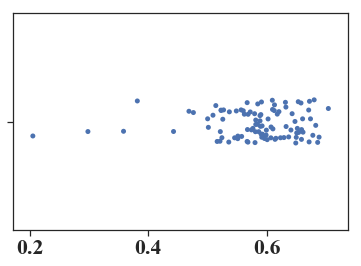

In [392]:
sns.stripplot(mean_scores)

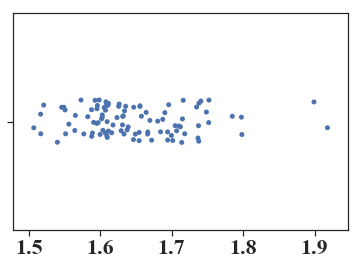

In [393]:
sns.stripplot(mean_maes)

### Varying min_samples_split parameter for RF

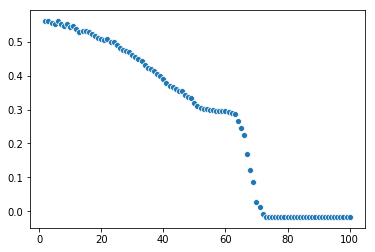

In [357]:
sns.scatterplot(x=range(2, 101), y=oob_scores)  # random_state = 10 (min_samples_split)

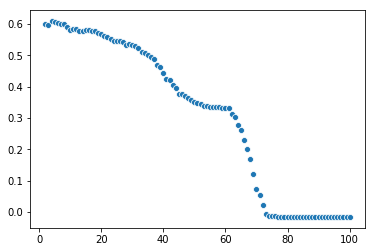

In [359]:
sns.scatterplot(x=range(2, 101), y=oob_scores)  # random_state = 11 (min_samples_split)

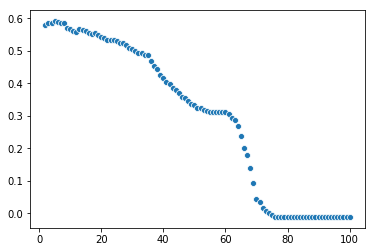

In [355]:
sns.scatterplot(x=range(2, 101), y=oob_scores)  # random_state = 12 (min_samples_split)